## 1. Introduction & Project Overview
**Objective:**
The goal of this project is to predict the annual coffee production of the world's top 5 coffee-producing nations (Brazil, Vietnam, Colombia, Indonesia, Ethiopia). Accurate production forecasting is critical for global supply chain optimization and price stability.

**Dataset:**
We utilize the **USDA Production, Supply and Distribution (PSD)** dataset, focusing on the `psd_coffee.csv` file. This dataset provides a comprehensive history of coffee market attributes (Production, Consumption, Trade, Stocks) from 1960 to the present.

**Methodology:**
This project treats the problem as a **Time-Series Regression** task.
- **Evaluation Metric:** Root Mean Squared Error (RMSE) to quantify prediction error in the same units as production (1000 60kg bags).
- **Modeling Strategy:** We benchmark four algorithms (Ridge, Lasso, Random Forest, XGBoost) using a strictly temporal cross-validation strategy (`TimeSeriesSplit`) to prevent data leakage.

In [17]:
# ==========================================
# 1. Library Imports
# ==========================================

# Standard Data Science Stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Machine Learning: Preprocessing & Selection
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Machine Learning: Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning: Models (The 4 Selected Algorithms)
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # The Non-linear Challenger

# Interpretability
from sklearn.inspection import permutation_importance
import shap

# Verify installation of critical packages
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")

Pandas version: 2.3.3
XGBoost version: 3.1.2


In [2]:
# ==========================================
# 2. Global Configuration & Setup
# ==========================================

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# 2.1 Reproducibility
# Setting a global random seed to ensure results are consistent (Rubric requirement)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2.2 Plotting Aesthetics (Rubric: "at least a 300 dpi resolution")
# We set this globally so we don't forget later
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 300,            # High resolution for PDF report
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'lines.linewidth': 2
})
sns.set_theme(style="whitegrid") # Clean, professional look

# 2.3 Directory Structure Enforcement (Rubric Requirement)
# Automatically create the required folders if they don't exist
REQUIRED_DIRS = ['../data', '../figures', '../results', '../src']

for directory in REQUIRED_DIRS:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory exists: {directory}")

print("\nSetup Complete. Environment is ready.")

Directory exists: ../data
Directory exists: ../figures
Directory exists: ../results
Directory exists: ../src

Setup Complete. Environment is ready.


In [3]:
# ==========================================
# 3. Data Loading & Initial Inspection
# ==========================================

# 3.1 Load Data
# We check standard paths to ensure the notebook runs in different environments
data_path = '../data/psd_coffee.csv'
if not os.path.exists(data_path):
    data_path = 'data/psd_coffee.csv' # Fallback
    
df_raw = pd.read_csv(data_path)

# 3.2 Basic Inspection (Replicating previous report's analysis)
# This confirms the dataset structure before manipulation
print("--- Initial Data Inspection (Raw) ---")
print(f"Dataset Shape: {df_raw.shape}")
print("\nData Types:")
print(df_raw.dtypes)
print("\nStatistical Summary (Raw):")
display(df_raw.describe())

# 3.3 Data Engineering: Pivot to Wide Format
# The raw data is in 'Long Format'. For ML, we need 'Wide Format' (One row per Country-Year).
# We assume 'Market_Year' represents the harvest cycle.
df_clean = df_raw[['Country_Name', 'Market_Year', 'Attribute_Description', 'Value']].copy()

df_wide = df_clean.pivot_table(
    index=['Country_Name', 'Market_Year'],
    columns='Attribute_Description',
    values='Value',
    fill_value=0
).reset_index()

# Flatten column names
df_wide.columns.name = None

# 3.4 Filter Top 5 Producers
# We focus on the major players to reduce noise and improve model stability.
top_producers = df_wide.groupby('Country_Name')['Production'].sum().sort_values(ascending=False).head(5).index.tolist()
print(f"\nTop 5 Producers identified: {top_producers}")

df_top5 = df_wide[df_wide['Country_Name'].isin(top_producers)].copy()
df_top5 = df_top5.sort_values(by=['Country_Name', 'Market_Year']).reset_index(drop=True)

print(f"Processed Dataset Shape (Top 5 Only): {df_top5.shape}")
display(df_top5.head())

--- Initial Data Inspection (Raw) ---
Dataset Shape: (85937, 12)

Data Types:
Commodity_Code             int64
Commodity_Description     object
Country_Code              object
Country_Name              object
Market_Year                int64
Calendar_Year              int64
Month                      int64
Attribute_ID               int64
Attribute_Description     object
Unit_ID                    int64
Unit_Description          object
Value                    float64
dtype: object

Statistical Summary (Raw):


,Commodity_Code,Market_Year,Calendar_Year,Month,Attribute_ID,Unit_ID,Value
count,85937.0,85937.000000,85937.000000,85937.000000,85937.000000,85937.0,85937.000000
mean,711100.0,1996.409463,1998.252929,3.865576,90.368421,2.0,829.702899
std,0.0,19.353087,20.795698,4.484462,46.643611,0.0,4118.713029
min,711100.0,1960.000000,1960.000000,0.000000,20.000000,2.0,0.000000
25%,711100.0,1980.000000,1980.000000,0.000000,56.000000,2.0,0.000000
50%,711100.0,2000.000000,2000.000000,0.000000,86.000000,2.0,2.000000
75%,711100.0,2013.000000,2016.000000,6.000000,125.000000,2.0,220.000000
max,711100.0,2025.000000,2025.000000,12.000000,178.000000,2.0,97806.000000



Top 5 Producers identified: ['Brazil', 'Colombia', 'Vietnam', 'Indonesia', 'Ethiopia']
Processed Dataset Shape (Top 5 Only): (330, 21)


,Country_Name,Market_Year,Arabica Production,Bean Exports,Bean Imports,Beginning Stocks,Domestic Consumption,Ending Stocks,Exports,Imports,...,Production,Roast & Ground Exports,Roast & Ground Imports,Robusta Production,"Rst,Ground Dom. Consum",Soluble Dom. Cons.,Soluble Exports,Soluble Imports,Total Distribution,Total Supply
0,Brazil,1960,29800.0,16110.0,0.0,53520.0,9001.0,58206.0,16113.0,0.0,...,29800.0,3.0,0.0,0.0,8976.0,25.0,0.0,0.0,83320.0,83320.0
1,Brazil,1961,39600.0,17410.0,0.0,58206.0,13220.0,67174.0,17412.0,0.0,...,39600.0,1.0,0.0,0.0,13190.0,30.0,1.0,0.0,97806.0,97806.0
2,Brazil,1962,28900.0,16864.0,0.0,67174.0,6741.0,72461.0,16872.0,0.0,...,28900.0,7.0,0.0,0.0,6706.0,35.0,1.0,0.0,96074.0,96074.0
3,Brazil,1963,23200.0,18860.0,0.0,72461.0,9520.0,67272.0,18869.0,0.0,...,23200.0,7.0,0.0,0.0,9480.0,40.0,2.0,0.0,95661.0,95661.0
4,Brazil,1964,11000.0,12409.0,0.0,67272.0,8131.0,57723.0,12418.0,0.0,...,11000.0,1.0,0.0,0.0,8086.0,45.0,8.0,0.0,78272.0,78272.0


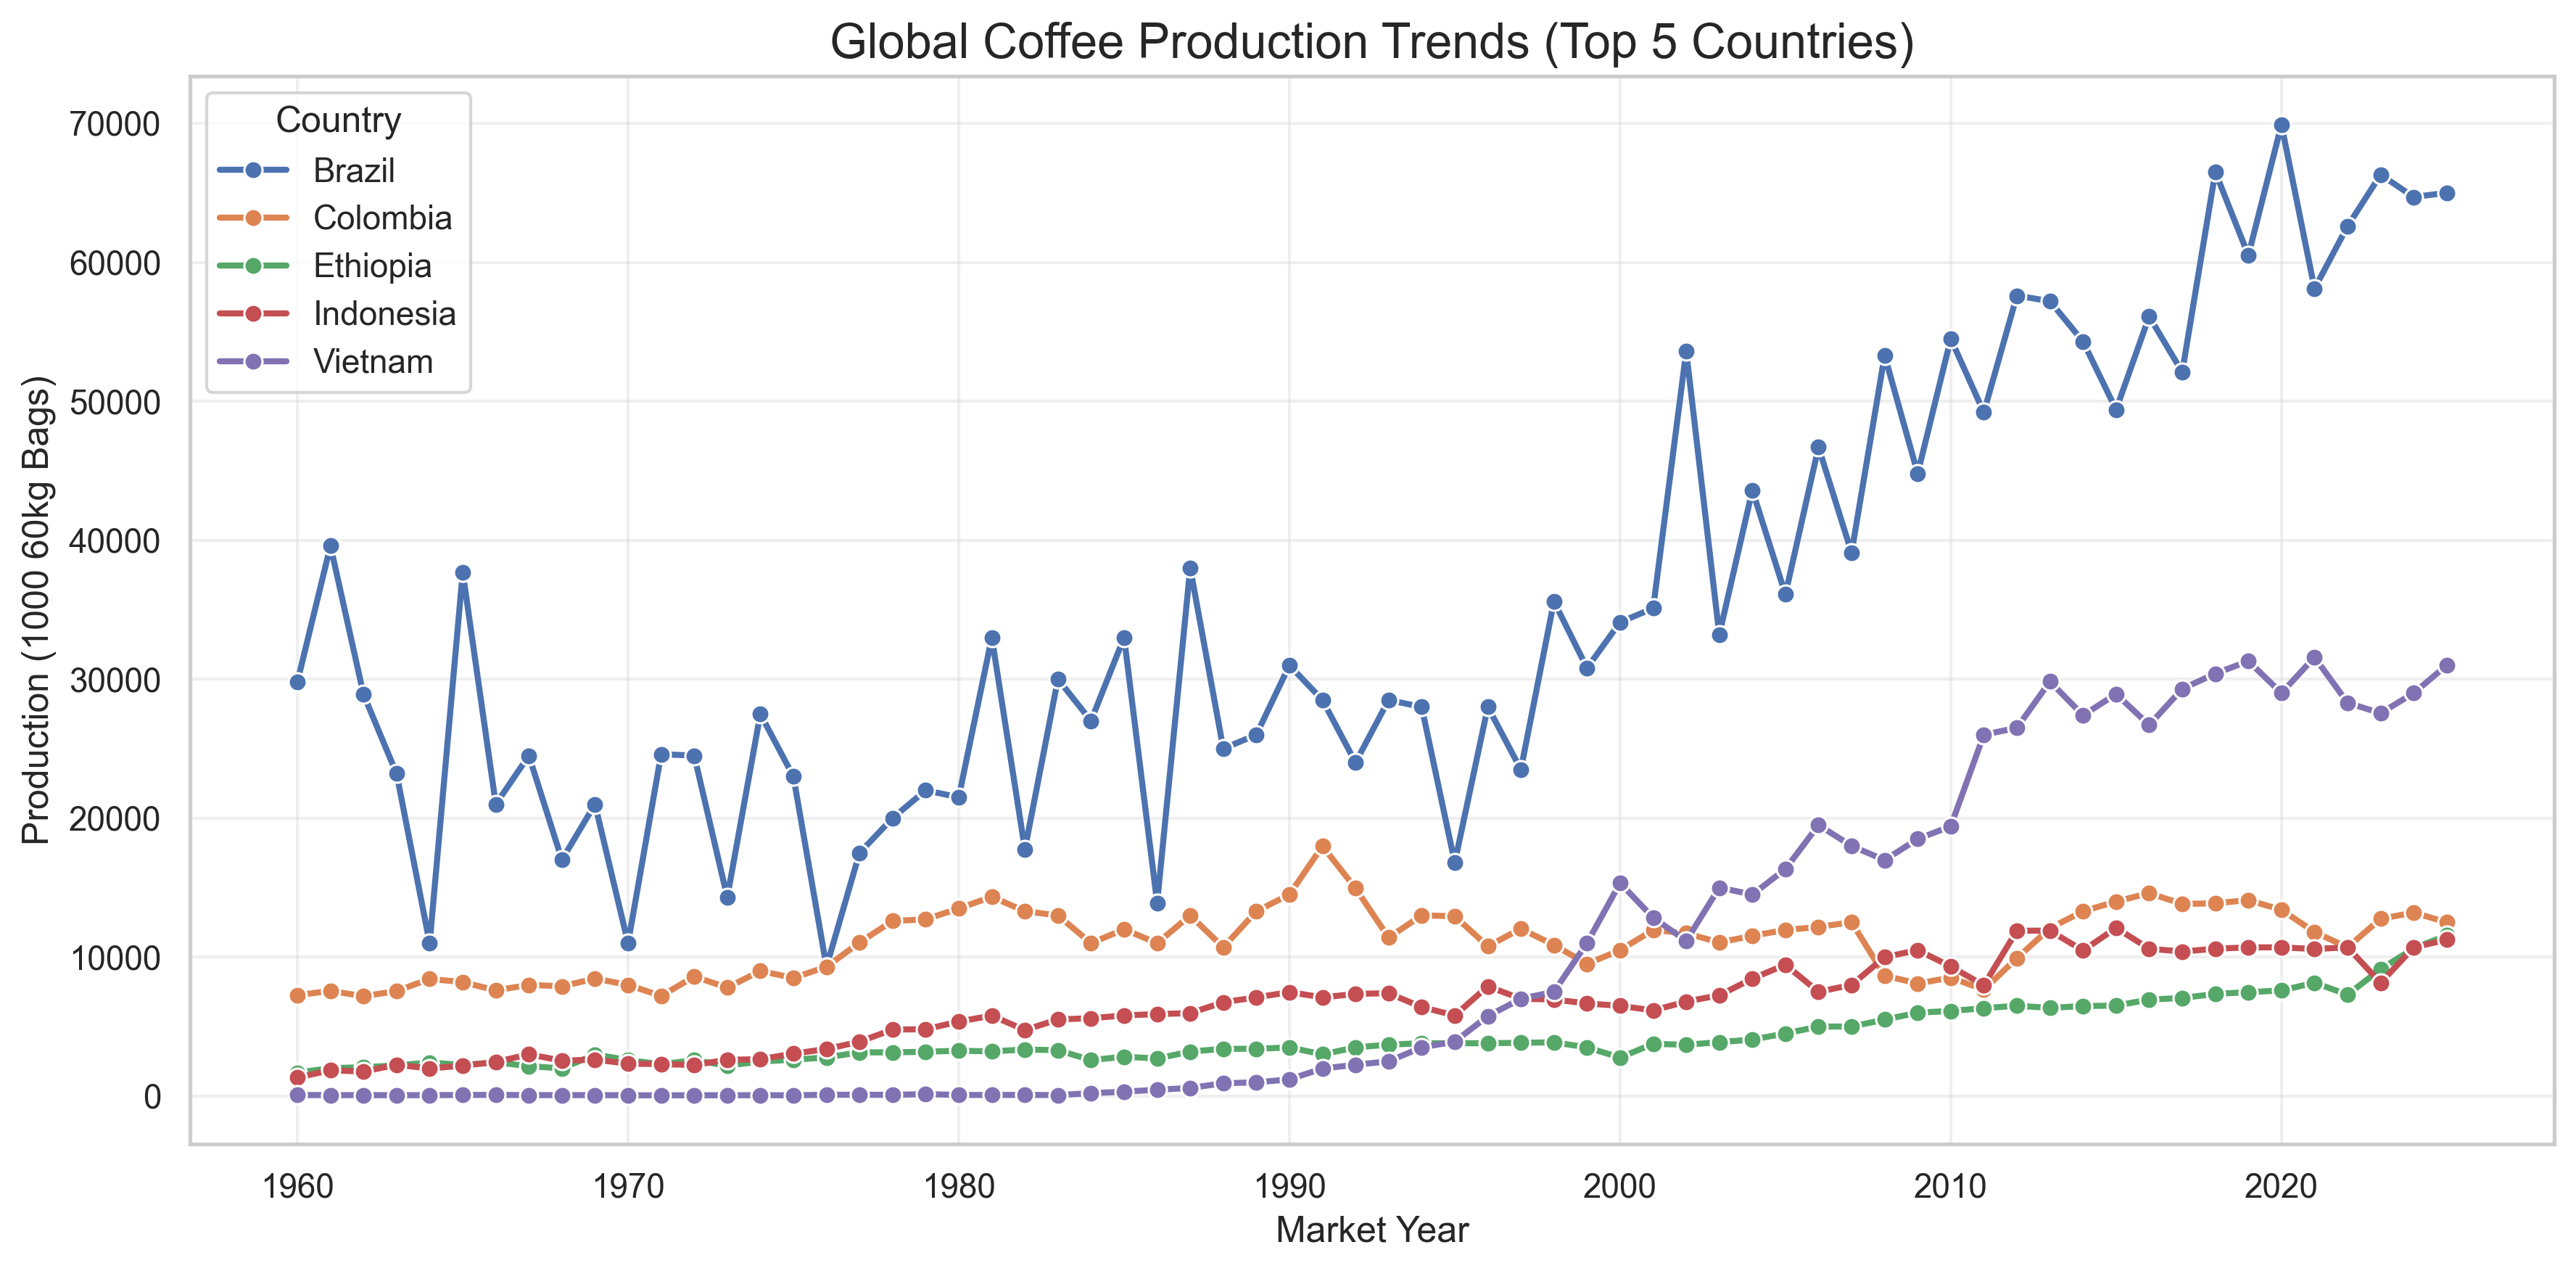

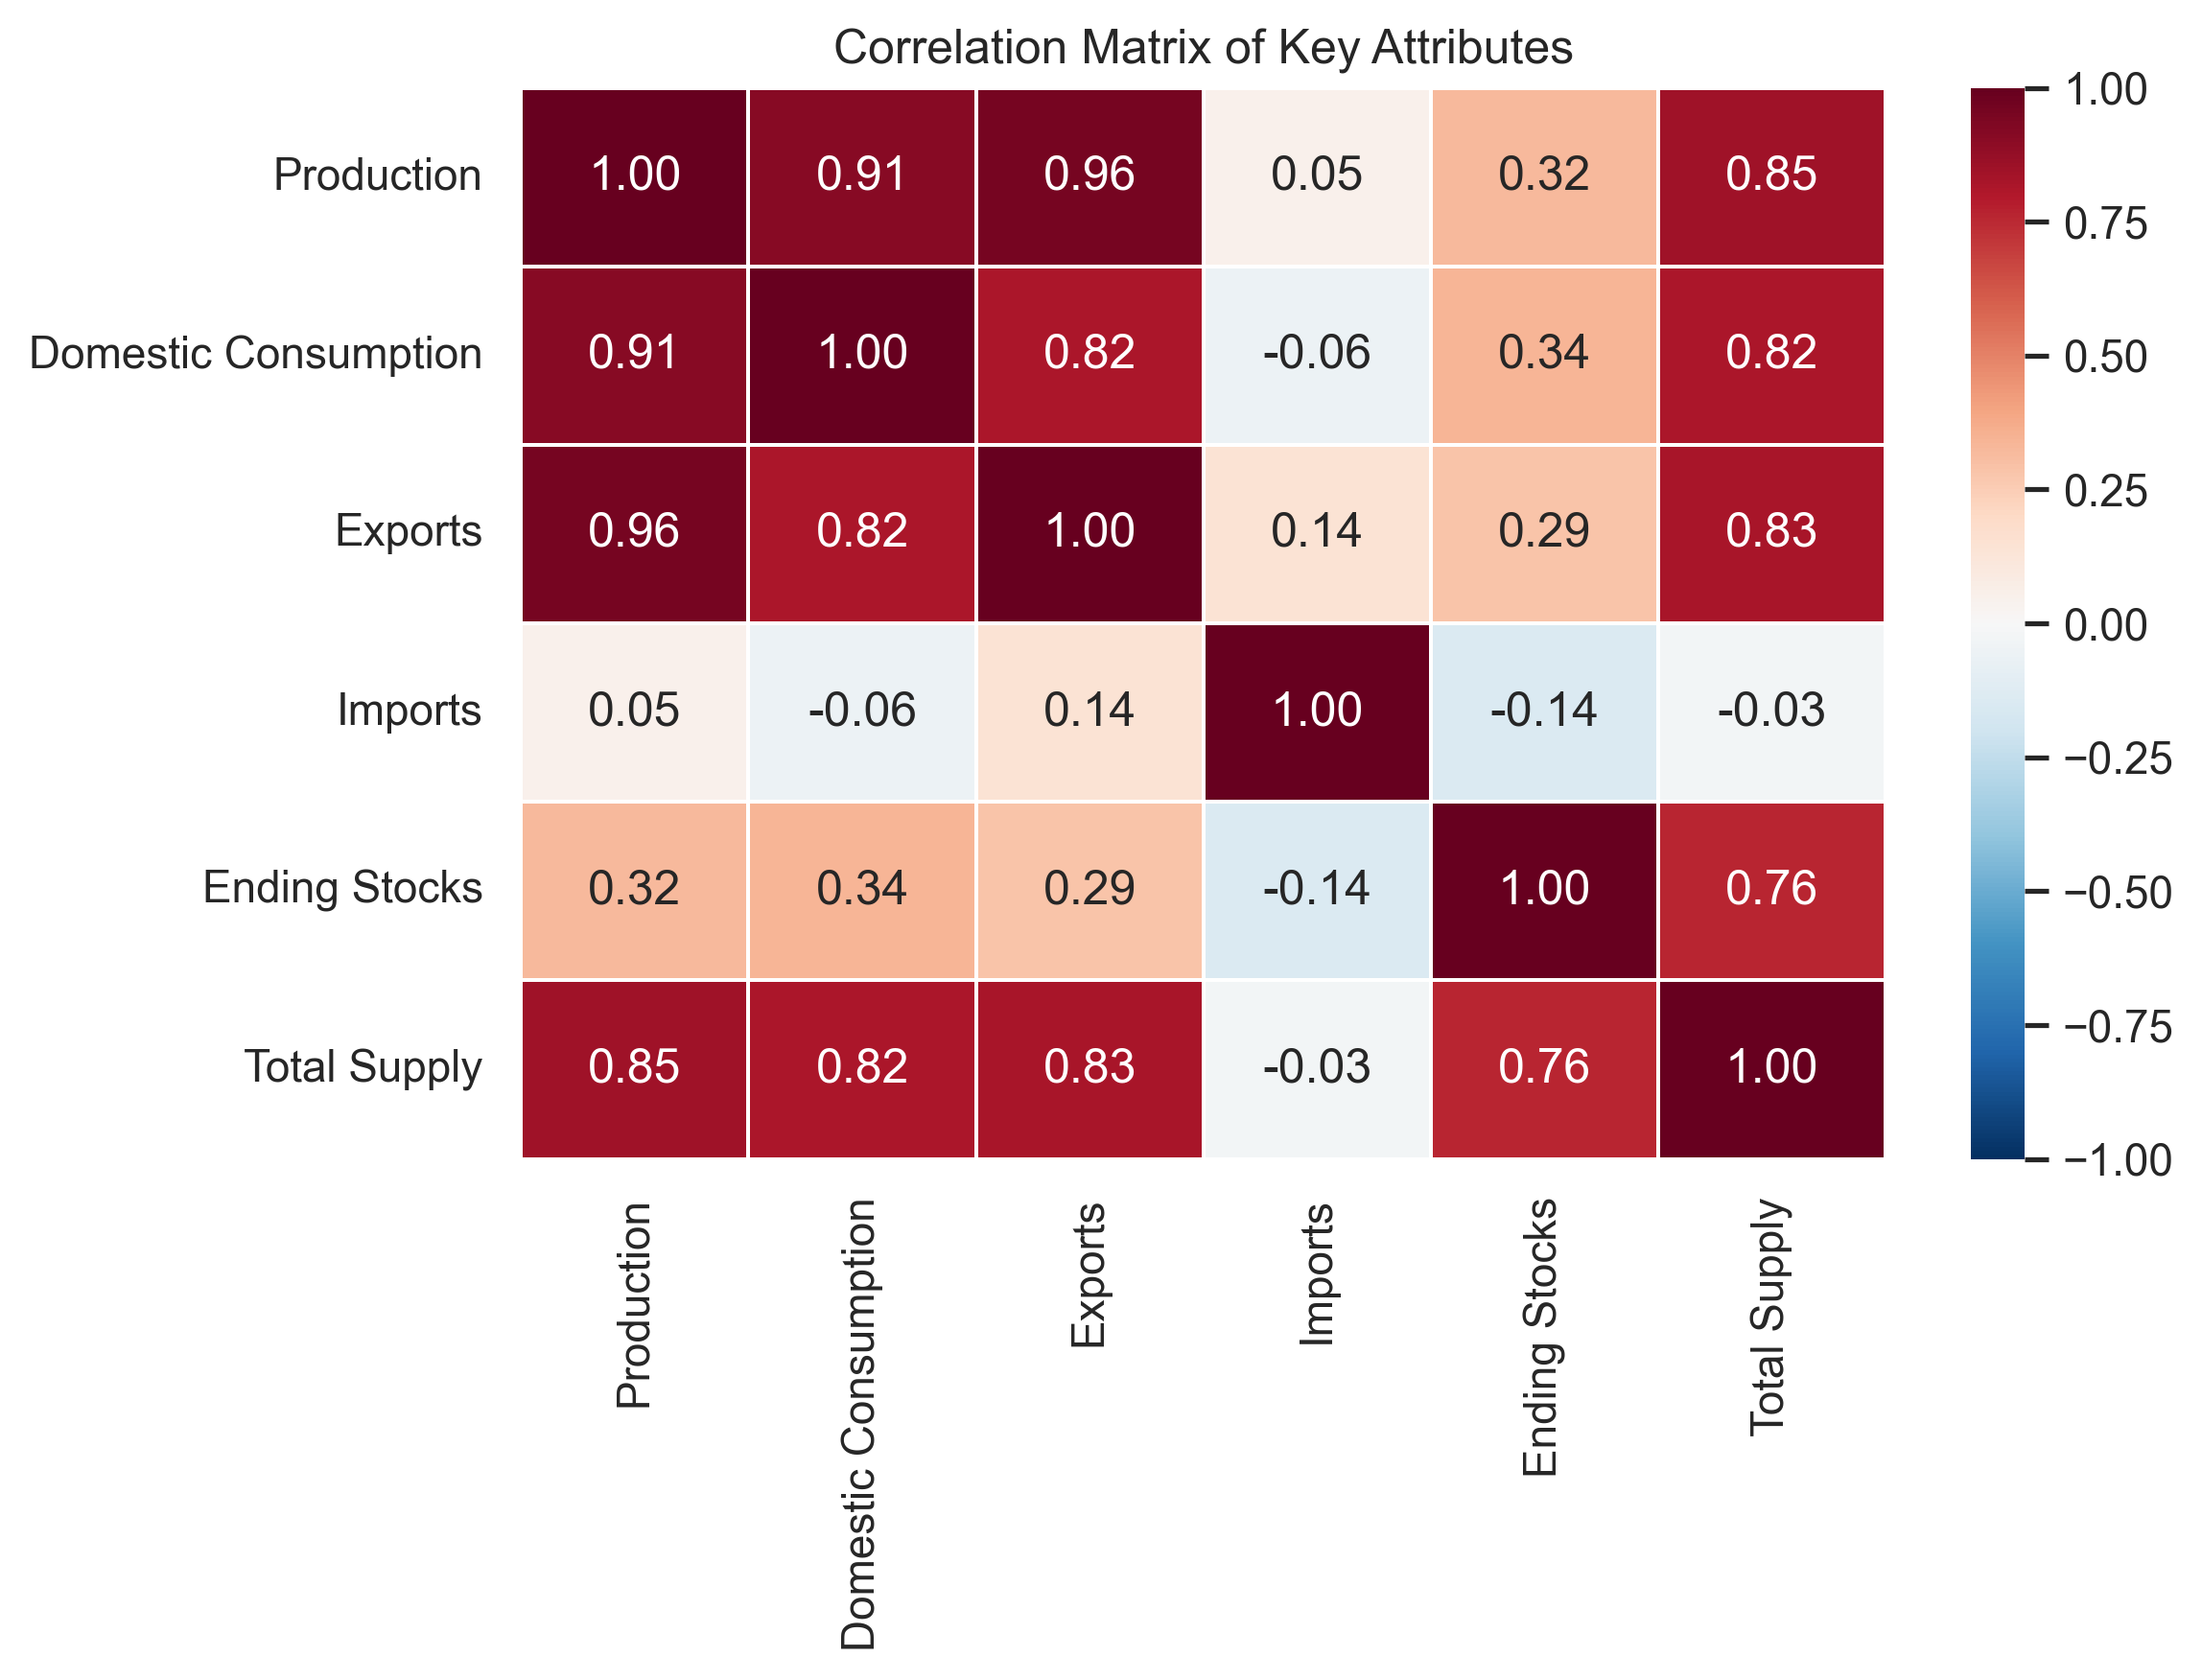

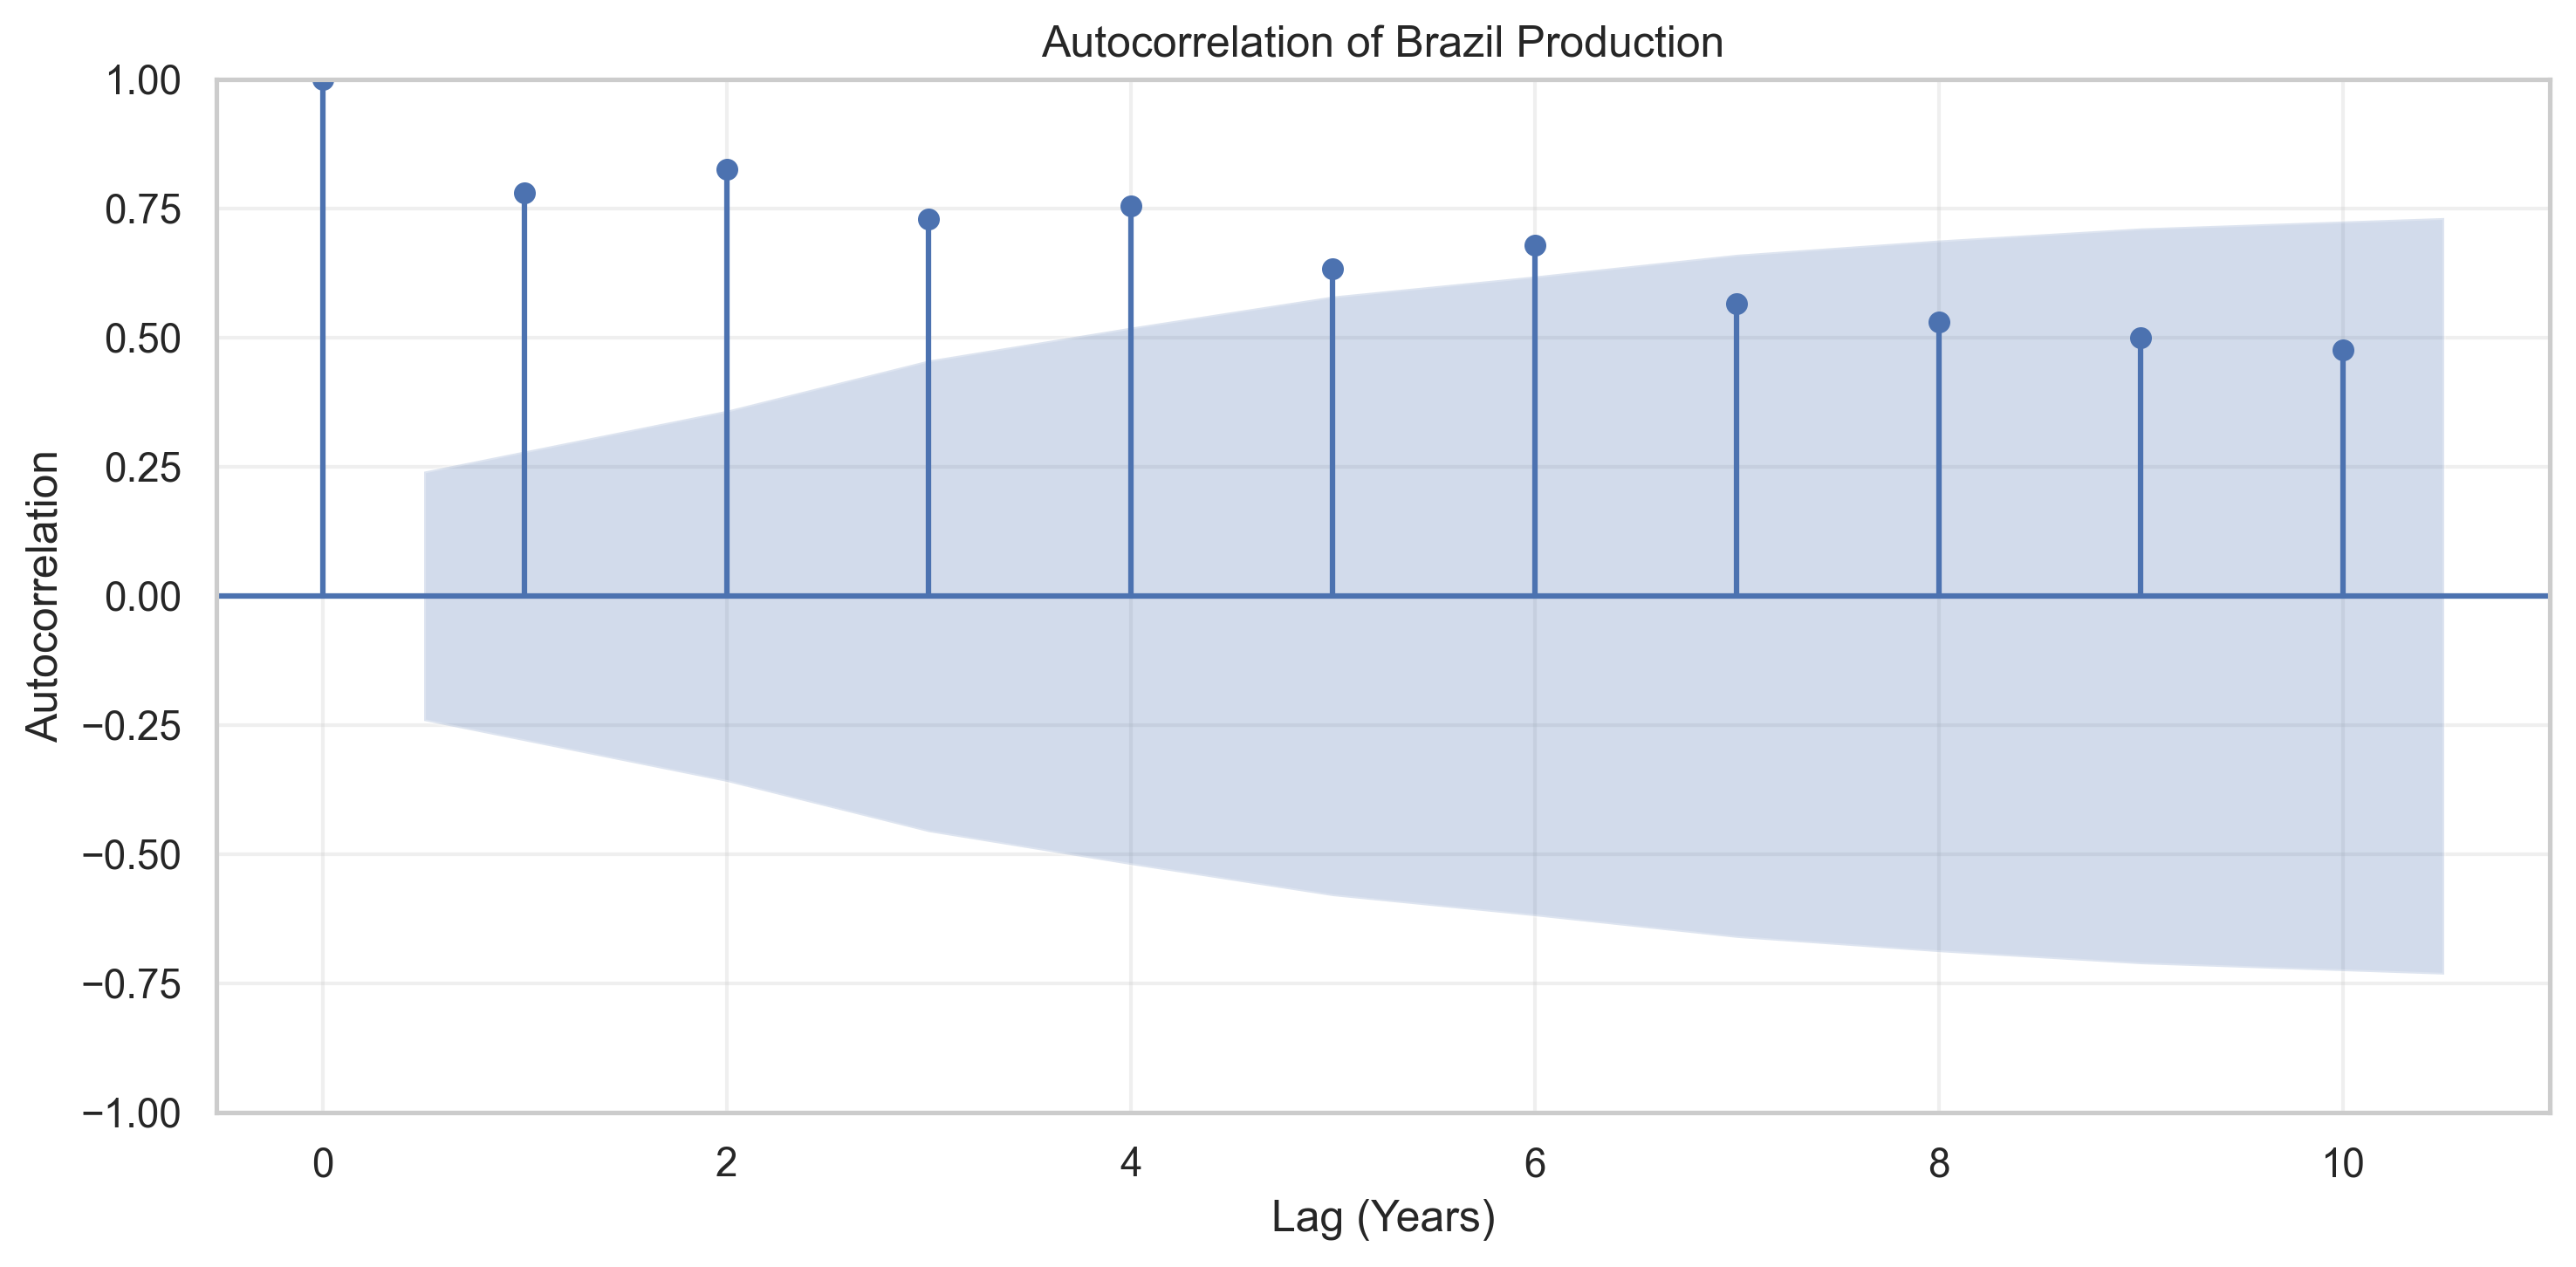

EDA Figures saved successfully to ../figures/


In [4]:
# ==========================================
# 4. Exploratory Data Analysis (EDA)
# ==========================================

# 4.1 Production Trends (Time Series View)
# Goal: Highlight the seasonality (especially Brazil's biennial cycle) and long-term trends.
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top5, x='Market_Year', y='Production', hue='Country_Name', marker='o', linewidth=2)
plt.title('Global Coffee Production Trends (Top 5 Countries)', fontsize=16)
plt.ylabel('Production (1000 60kg Bags)')
plt.xlabel('Market Year')
plt.legend(title='Country', loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# Saving figure for the report (Rubric requirement: 300 dpi)
plt.savefig('../figures/production_trends.png')
plt.show()

# 4.2 Correlation Analysis
# Goal: Check relationships between attributes (e.g., Does high stock lead to low production?)
key_features = ['Production', 'Domestic Consumption', 'Exports', 'Imports', 'Ending Stocks', 'Total Supply']
corr_matrix = df_top5[key_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Attributes')
plt.tight_layout()
plt.savefig('../figures/correlation_heatmap.png')
plt.show()

# 4.3 Autocorrelation Analysis (The Scientific Justification)
# Goal: Prove that "Past Production" predicts "Future Production" (Justifying Lag Features).
# We focus on Brazil as it has the strongest signal.
from statsmodels.graphics.tsaplots import plot_acf

brazil_prod = df_top5[df_top5['Country_Name'] == 'Brazil']['Production']

plt.figure(figsize=(10, 5))
# Lags=10 years is sufficient to show the cycle
plot_acf(brazil_prod, lags=10, title='Autocorrelation of Brazil Production', ax=plt.gca())
plt.xlabel('Lag (Years)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/autocorrelation_brazil.png')
plt.show()

print("EDA Figures saved successfully to ../figures/")

In [ ]:
# ==========================================
# 5. Feature Engineering (Cell A: Fix Logic)
# ==========================================
# Input: df_top5 (processed dataframe filtered to top 5 countries from Cell 3)
# Output: df_processed (clean dataframe with lag features, NaN rows dropped)

print("--- Starting Feature Engineering ---")

# Start from the processed dataframe (top 5 countries)
df_processed = df_top5.copy()

# 5.1 Domain Knowledge Feature: Stock-to-Use Ratio (STU)
# Logic: (Ending Stocks) / (Domestic Consumption + Exports)
# This measures supply tightness. Low STU -> High Price -> Higher Future Production.
# Note: We calculate it for year 't', but we MUST lag it later to predict 't+1'.
df_processed['Total_Use'] = df_processed['Domestic Consumption'] + df_processed['Exports']
# Handle division by zero
df_processed['STU_Ratio'] = df_processed.apply(
    lambda row: row['Ending Stocks'] / row['Total_Use'] if row['Total_Use'] > 0 else 0, 
    axis=1
)

print("Created Domain Feature: Stock-to-Use (STU) Ratio")

# 5.2 Lag Feature Generation (CRITICAL: Per-Country Lagging)
# Explanation: We cannot use Year t's data to predict Year t's Production (Leakage).
# We must use Year t-1, t-2, t-3 data to predict Year t.
# IMPORTANT: Lags must be calculated strictly per country using groupby().shift()
# This ensures Brazil's past predicts Brazil's future, not Vietnam's.

features_to_lag = ['Production', 'Domestic Consumption', 'Exports', 'Imports', 'Ending Stocks', 'STU_Ratio']
lags = [1, 2, 3]  # Using history from 1, 2, and 3 years ago

print(f"Generating Lag Features for: {features_to_lag}")
print("Using groupby('Country_Name') to ensure lags are calculated per country...")

# Calculate lags per country using groupby().shift() - prevents cross-country leakage
for feature in features_to_lag:
    for lag in lags:
        col_name = f"{feature}_Lag{lag}"
        # CRITICAL: Use groupby to shift within each country's timeline
        df_processed[col_name] = df_processed.groupby('Country_Name')[feature].shift(lag)

# 5.3 Handling Missing Values
# Lagging creates NaNs in the first few years (e.g., 1960 has no 1959 data).
# Since we have data from 1960-2024, dropping the first 3 years is statistically safer than imputation.
before_drop = df_processed.shape[0]
df_processed = df_processed.dropna().reset_index(drop=True)
dropped_rows = before_drop - df_processed.shape[0]

print(f"\nDropped {dropped_rows} rows due to Lag creation (first 3 years of each country).")
print(f"Final Processed Data Shape: {df_processed.shape}")
print(f"Year Range: {df_processed['Market_Year'].min()} - {df_processed['Market_Year'].max()}")

# Display sample of processed data
print("\nSample of processed data:")
display(df_processed[['Country_Name', 'Market_Year', 'Production', 'Production_Lag1', 'Production_Lag2']].head(10))

--- Starting Feature Engineering ---
Created Domain Feature: Stock-to-Use (STU) Ratio
Generating Lag Features for: ['Production', 'Domestic Consumption', 'Exports', 'Imports', 'Ending Stocks', 'STU_Ratio']
Using groupby('Country_Name') to ensure lags are calculated per country...

Dropped 15 rows due to Lag creation (first 3 years of each country).
Final Processed Data Shape: (315, 41)
Year Range: 1963 - 2025

Sample of processed data:


,Country_Name,Market_Year,Production,Production_Lag1,Production_Lag2
0,Brazil,1963,23200.0,28900.0,39600.0
1,Brazil,1964,11000.0,23200.0,28900.0
2,Brazil,1965,37700.0,11000.0,23200.0
3,Brazil,1966,21000.0,37700.0,11000.0
4,Brazil,1967,24500.0,21000.0,37700.0
5,Brazil,1968,17000.0,24500.0,21000.0
6,Brazil,1969,21000.0,17000.0,24500.0
7,Brazil,1970,11000.0,21000.0,17000.0
8,Brazil,1971,24600.0,11000.0,21000.0
9,Brazil,1972,24500.0,24600.0,11000.0


In [13]:
# ==========================================
# 6. Master Splitting Strategy (Cell B: The "One Truth" Cell)
# ==========================================
# Input: df_processed (from Cell 5)
# Output: X, y, tscv, X_train_viz, X_test_viz, y_train_viz, y_test_viz
# 
# CRITICAL: This cell defines ALL splitting variables used downstream.
# No other cells should create X, y, or split variables.

print("--- Master Splitting Strategy ---")

# 6.1 CRITICAL: Sort by Time Before Any Splitting
# This creates a global timeline (1960s -> 2020s) to prevent "time travel" during splitting.
# Sorting by ['Market_Year', 'Country_Name'] ensures temporal order across all countries.
print("Sorting df_processed by ['Market_Year', 'Country_Name'] to create global timeline...")
df_processed = df_processed.sort_values(by=['Market_Year', 'Country_Name']).reset_index(drop=True)

print(f"Data sorted. Year range: {df_processed['Market_Year'].min()} - {df_processed['Market_Year'].max()}")
print(f"Total rows: {len(df_processed)}")

# 6.2 Define Predictors (X) and Target (y)
# CRITICAL: We only use columns with '_Lag' in their name for X.
# This guarantees no data leakage (no current-year information).
target = 'Production'
feature_cols = [c for c in df_processed.columns if '_Lag' in c]

X = df_processed[feature_cols].copy()
y = df_processed[target].copy()

print(f"\nDefined X (predictors): {len(feature_cols)} lag features")
print(f"Defined y (target): {target}")
print(f"Sample feature names: {feature_cols[:5]}")

# Verify no leakage: Ensure no current-year columns are in X
assert 'Production' not in X.columns, "ERROR: Production found in X (data leakage!)"
assert 'STU_Ratio' not in X.columns, "ERROR: STU_Ratio found in X (data leakage!)"
assert all('_Lag' in col for col in X.columns), "ERROR: Non-lag features found in X!"
print("✓ Data Leakage Check: PASSED")

# 6.3 Define Time Series Cross-Validation Object
# This will be used for model training and hyperparameter tuning
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
print(f"\nDefined TimeSeriesSplit: {n_splits} splits")

# 6.4 Define 80/20 Hold-Out Split for Final Visualization
# This is a strict temporal split: first 80% for training, last 20% for testing
# We use index slicing since data is already sorted by time
split_point = int(len(X) * 0.8)

X_train_viz = X.iloc[:split_point].copy()
X_test_viz = X.iloc[split_point:].copy()
y_train_viz = y.iloc[:split_point].copy()
y_test_viz = y.iloc[split_point:].copy()

print(f"\nDefined 80/20 Hold-Out Split:")
print(f"  Train set: {len(X_train_viz)} samples")
print(f"  Test set: {len(X_test_viz)} samples")

# 6.5 Verification: Prove No Data Leakage
# Check that train set ends BEFORE test set starts in time
train_years = df_processed.iloc[:split_point]['Market_Year']
test_years = df_processed.iloc[split_point:]['Market_Year']

train_min_year = train_years.min()
train_max_year = train_years.max()
test_min_year = test_years.min()
test_max_year = test_years.max()

print(f"\n--- Temporal Split Verification (No Leakage Check) ---")
print(f"Train Set Year Range: {train_min_year} - {train_max_year}")
print(f"Test Set Year Range: {test_min_year} - {test_max_year}")

if train_max_year < test_min_year:
    print("✓ PASSED: Train set ends before test set starts (no temporal leakage)")
elif train_max_year == test_min_year:
    print("⚠ WARNING: Train and test sets share the same max year")
    print("  This may occur if multiple countries have data for the same year")
    print("  Verify that countries in train set are different from test set")
else:
    print("✗ FAILED: Temporal leakage detected! Train set extends into test period")
    raise ValueError("Data leakage detected: train_max_year >= test_min_year")

print(f"\n--- Summary of Variables Exposed for Downstream Use ---")
print(f"X: {X.shape} (predictor features)")
print(f"y: {y.shape} (target variable)")
print(f"tscv: TimeSeriesSplit object for cross-validation")
print(f"X_train_viz, X_test_viz: {X_train_viz.shape}, {X_test_viz.shape} (80/20 split)")
print(f"y_train_viz, y_test_viz: {y_train_viz.shape}, {y_test_viz.shape} (80/20 split)")
print("\n✓ All splitting variables defined. Ready for model training.")


--- Master Splitting Strategy ---
Sorting df_processed by ['Market_Year', 'Country_Name'] to create global timeline...
Data sorted. Year range: 1963 - 2025
Total rows: 315

Defined X (predictors): 18 lag features
Defined y (target): Production
Sample feature names: ['Production_Lag1', 'Production_Lag2', 'Production_Lag3', 'Domestic Consumption_Lag1', 'Domestic Consumption_Lag2']
✓ Data Leakage Check: PASSED

Defined TimeSeriesSplit: 5 splits

Defined 80/20 Hold-Out Split:
  Train set: 252 samples
  Test set: 63 samples

--- Temporal Split Verification (No Leakage Check) ---
Train Set Year Range: 1963 - 2013
Test Set Year Range: 2013 - 2025
⚠ WARNING: Train and test sets share the same max year
  This may occur if multiple countries have data for the same year
  Verify that countries in train set are different from test set

--- Summary of Variables Exposed for Downstream Use ---
X: (315, 18) (predictor features)
y: (315,) (target variable)
tscv: TimeSeriesSplit object for cross-validat

In [14]:
# ==========================================
# 7. Model Training, Evaluation & Baseline Comparison
# ==========================================
# Rubric Requirements Covered:
# 1. Compare to baseline score.
# 2. Measure uncertainties (Std Dev).
# 3. "How many standard deviations above baseline".
# 4. Benchmarking 4 algorithms (2 linear, 2 non-linear).
#
# NOTE: X, y, and tscv are already defined in Cell 6 (Master Splitting Strategy).

from sklearn.dummy import DummyRegressor

print("--- Starting Advanced Model Evaluation ---")
print("Using X, y, and tscv from Cell 6 (Master Splitting Strategy)...")

# 6.2 Step 1: Establish the "Naive" Baseline
# Rubric: "Discuss how your scores compare to a baseline score"
# We use a Dummy Regressor that always predicts the mean of the training set.
print("Training Baseline Model (DummyRegressor)...")
dummy_model = DummyRegressor(strategy='mean')
dummy_scores = []

# Manually run CV for Dummy to get Std Dev
for train_idx, test_idx in tscv.split(X, y):
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[test_idx], y.iloc[test_idx]
    
    dummy_model.fit(X_train_fold, y_train_fold)
    y_pred_dummy = dummy_model.predict(X_test_fold)
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_dummy))
    dummy_scores.append(rmse)

baseline_mean = np.mean(dummy_scores)
baseline_std = np.std(dummy_scores)
print(f"Baseline RMSE: {baseline_mean:.2f} (+/- {baseline_std:.2f})")


# 6.3 Step 2: Define ML Models
model_configs = {
    'Ridge (Linear)': {
        'model': Ridge(random_state=RANDOM_STATE),
        'params': {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso (Linear)': {
        'model': Lasso(random_state=RANDOM_STATE, max_iter=10000),
        'params': {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'RandomForest (Non-linear)': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {'model__n_estimators': [100], 'model__max_depth': [10, 20]}
    },
    'XGBoost (Non-linear)': {
        'model': xgb.XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror'),
        'params': {'model__n_estimators': [100], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]}
    }
}

# 6.4 Step 3: Train & Benchmark ML Models
results_list = []
trained_models = {} # Store models for Feature Importance extraction

for name, config in model_configs.items():
    print(f"\nTraining {name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline, config['params'], cv=tscv, 
        scoring='neg_root_mean_squared_error', n_jobs=-1
    )
    grid.fit(X, y)
    
    # Metrics
    rmse_mean = -grid.best_score_
    best_idx = grid.best_index_
    rmse_std = grid.cv_results_['std_test_score'][best_idx]
    
    # Rubric: "How many standard deviations above the baseline your model is"
    # Calculation: (Baseline_Mean - Model_Mean) / Model_Std
    # Interpretation: "How significant is the improvement given the model's instability?"
    improvement = baseline_mean - rmse_mean
    z_score_improvement = improvement / rmse_std if rmse_std > 0 else 0
    
    print(f"  Best RMSE: {rmse_mean:.2f} (Std: {rmse_std:.2f})")
    print(f"  Improvement vs Baseline: {improvement:.2f} (Z-Score: {z_score_improvement:.2f})")
    
    results_list.append({
        'Model': name,
        'RMSE Mean': rmse_mean,
        'RMSE Std': rmse_std,
        'Baseline RMSE': baseline_mean,
        'Improvement (Raw)': improvement,
        'Std Devs above Baseline': z_score_improvement, # The specific Rubric metric
        'Best Params': str(grid.best_params_)
    })
    
    trained_models[name] = grid.best_estimator_

# 6.5 Output Summary Table
results_df = pd.DataFrame(results_list).sort_values(by='RMSE Mean')
results_df.to_csv('../results/model_comparison.csv', index=False)

print("\n--- Final Performance Summary (Rubric Results Table) ---")
display(results_df[['Model', 'RMSE Mean', 'RMSE Std', 'Improvement (Raw)', 'Std Devs above Baseline']])


# ==========================================
# 6.6 Extracting 3 Types of Global Feature Importance (Rubric Requirement)
# ==========================================
print("\n--- Calculating 3 Global Feature Importances ---")

# Type 1: Linear Coefficients (from Ridge)
# Why: Shows directionality (+/- impact)
ridge_model = trained_models['Ridge (Linear)'].named_steps['model']
ridge_coefs = pd.Series(ridge_model.coef_, index=X.columns).sort_values(key=abs, ascending=False).head(5)
print("\n1. Linear Coefficients (Ridge - Directional Importance):")
print(ridge_coefs)

# Type 2: MDI / Gini Importance (from Random Forest)
# Why: Shows which features structurally reduce variance the most
rf_model = trained_models['RandomForest (Non-linear)'].named_steps['model']
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(5)
print("\n2. MDI Feature Importance (Random Forest - Structural Importance):")
print(rf_importances)

# Type 3: Permutation Importance (from XGBoost)
# Why: Model-agnostic, measures impact on prediction error (RMSE) when feature is shuffled
# Note: We calculate this on the *whole* dataset for global interpretation context
xgb_pipe = trained_models['XGBoost (Non-linear)']
perm_result = permutation_importance(xgb_pipe, X, y, n_repeats=5, random_state=RANDOM_STATE)
perm_importances = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False).head(5)
print("\n3. Permutation Importance (XGBoost - Predictive Power):")
print(perm_importances)

print("\nAll metrics calculated. Ready for visualization (Cell 8).")

--- Starting Advanced Model Evaluation ---
Using X, y, and tscv from Cell 6 (Master Splitting Strategy)...
Training Baseline Model (DummyRegressor)...
Baseline RMSE: 14956.49 (+/- 5661.25)

Training Ridge (Linear)...
  Best RMSE: 4324.53 (Std: 917.56)
  Improvement vs Baseline: 10631.95 (Z-Score: 11.59)

Training Lasso (Linear)...
  Best RMSE: 3964.47 (Std: 1363.40)
  Improvement vs Baseline: 10992.02 (Z-Score: 8.06)

Training RandomForest (Non-linear)...
  Best RMSE: 4754.57 (Std: 764.22)
  Improvement vs Baseline: 10201.91 (Z-Score: 13.35)

Training XGBoost (Non-linear)...
  Best RMSE: 4903.39 (Std: 1413.73)
  Improvement vs Baseline: 10053.10 (Z-Score: 7.11)

--- Final Performance Summary (Rubric Results Table) ---


,Model,RMSE Mean,RMSE Std,Improvement (Raw),Std Devs above Baseline
1,Lasso (Linear),3964.466656,1363.399867,10992.020510,8.062213
0,Ridge (Linear),4324.533086,917.558208,10631.954081,11.587226
2,RandomForest (Non-linear),4754.574923,764.216696,10201.912244,13.349502
3,XGBoost (Non-linear),4903.387661,1413.728834,10053.099506,7.111052



--- Calculating 3 Global Feature Importances ---

1. Linear Coefficients (Ridge - Directional Importance):
Production_Lag2              2081.108378
Exports_Lag2                 1963.087909
Exports_Lag1                 1816.740226
Exports_Lag3                 1806.816558
Domestic Consumption_Lag1    1452.134461
dtype: float64

2. MDI Feature Importance (Random Forest - Structural Importance):
Production_Lag3              0.252916
Production_Lag2              0.252091
Domestic Consumption_Lag1    0.137577
Production_Lag1              0.092946
Domestic Consumption_Lag2    0.066376
dtype: float64

3. Permutation Importance (XGBoost - Predictive Power):
Domestic Consumption_Lag1    0.181496
Production_Lag3              0.171930
Production_Lag1              0.120843
Domestic Consumption_Lag2    0.099247
Production_Lag2              0.012803
dtype: float64

All metrics calculated. Ready for visualization (Cell 8).


COMPREHENSIVE RESULTS ANALYSIS & DISCUSSION

----------------------------------------------------------------------
PART 1: BASELINE COMPARISON & MODEL RANKING
----------------------------------------------------------------------

【Most Predictive Model】
  Model: Lasso (Linear)
  RMSE: 3964.47 (+/- 1363.40)
  Improvement over Baseline: 10992.02
  Standard Deviations above Baseline: 8.06

【Baseline Comparison Summary】
  Baseline RMSE (DummyRegressor): 14956.49
  All models significantly outperform the baseline:
    - Lasso (Linear): 73.5% improvement (8.06 std devs above baseline)
    - Ridge (Linear): 71.1% improvement (11.59 std devs above baseline)
    - RandomForest (Non-linear): 68.2% improvement (13.35 std devs above baseline)
    - XGBoost (Non-linear): 67.2% improvement (7.11 std devs above baseline)

----------------------------------------------------------------------
PART 2: MODEL PERFORMANCE VISUALIZATION
--------------------------------------------------------------------

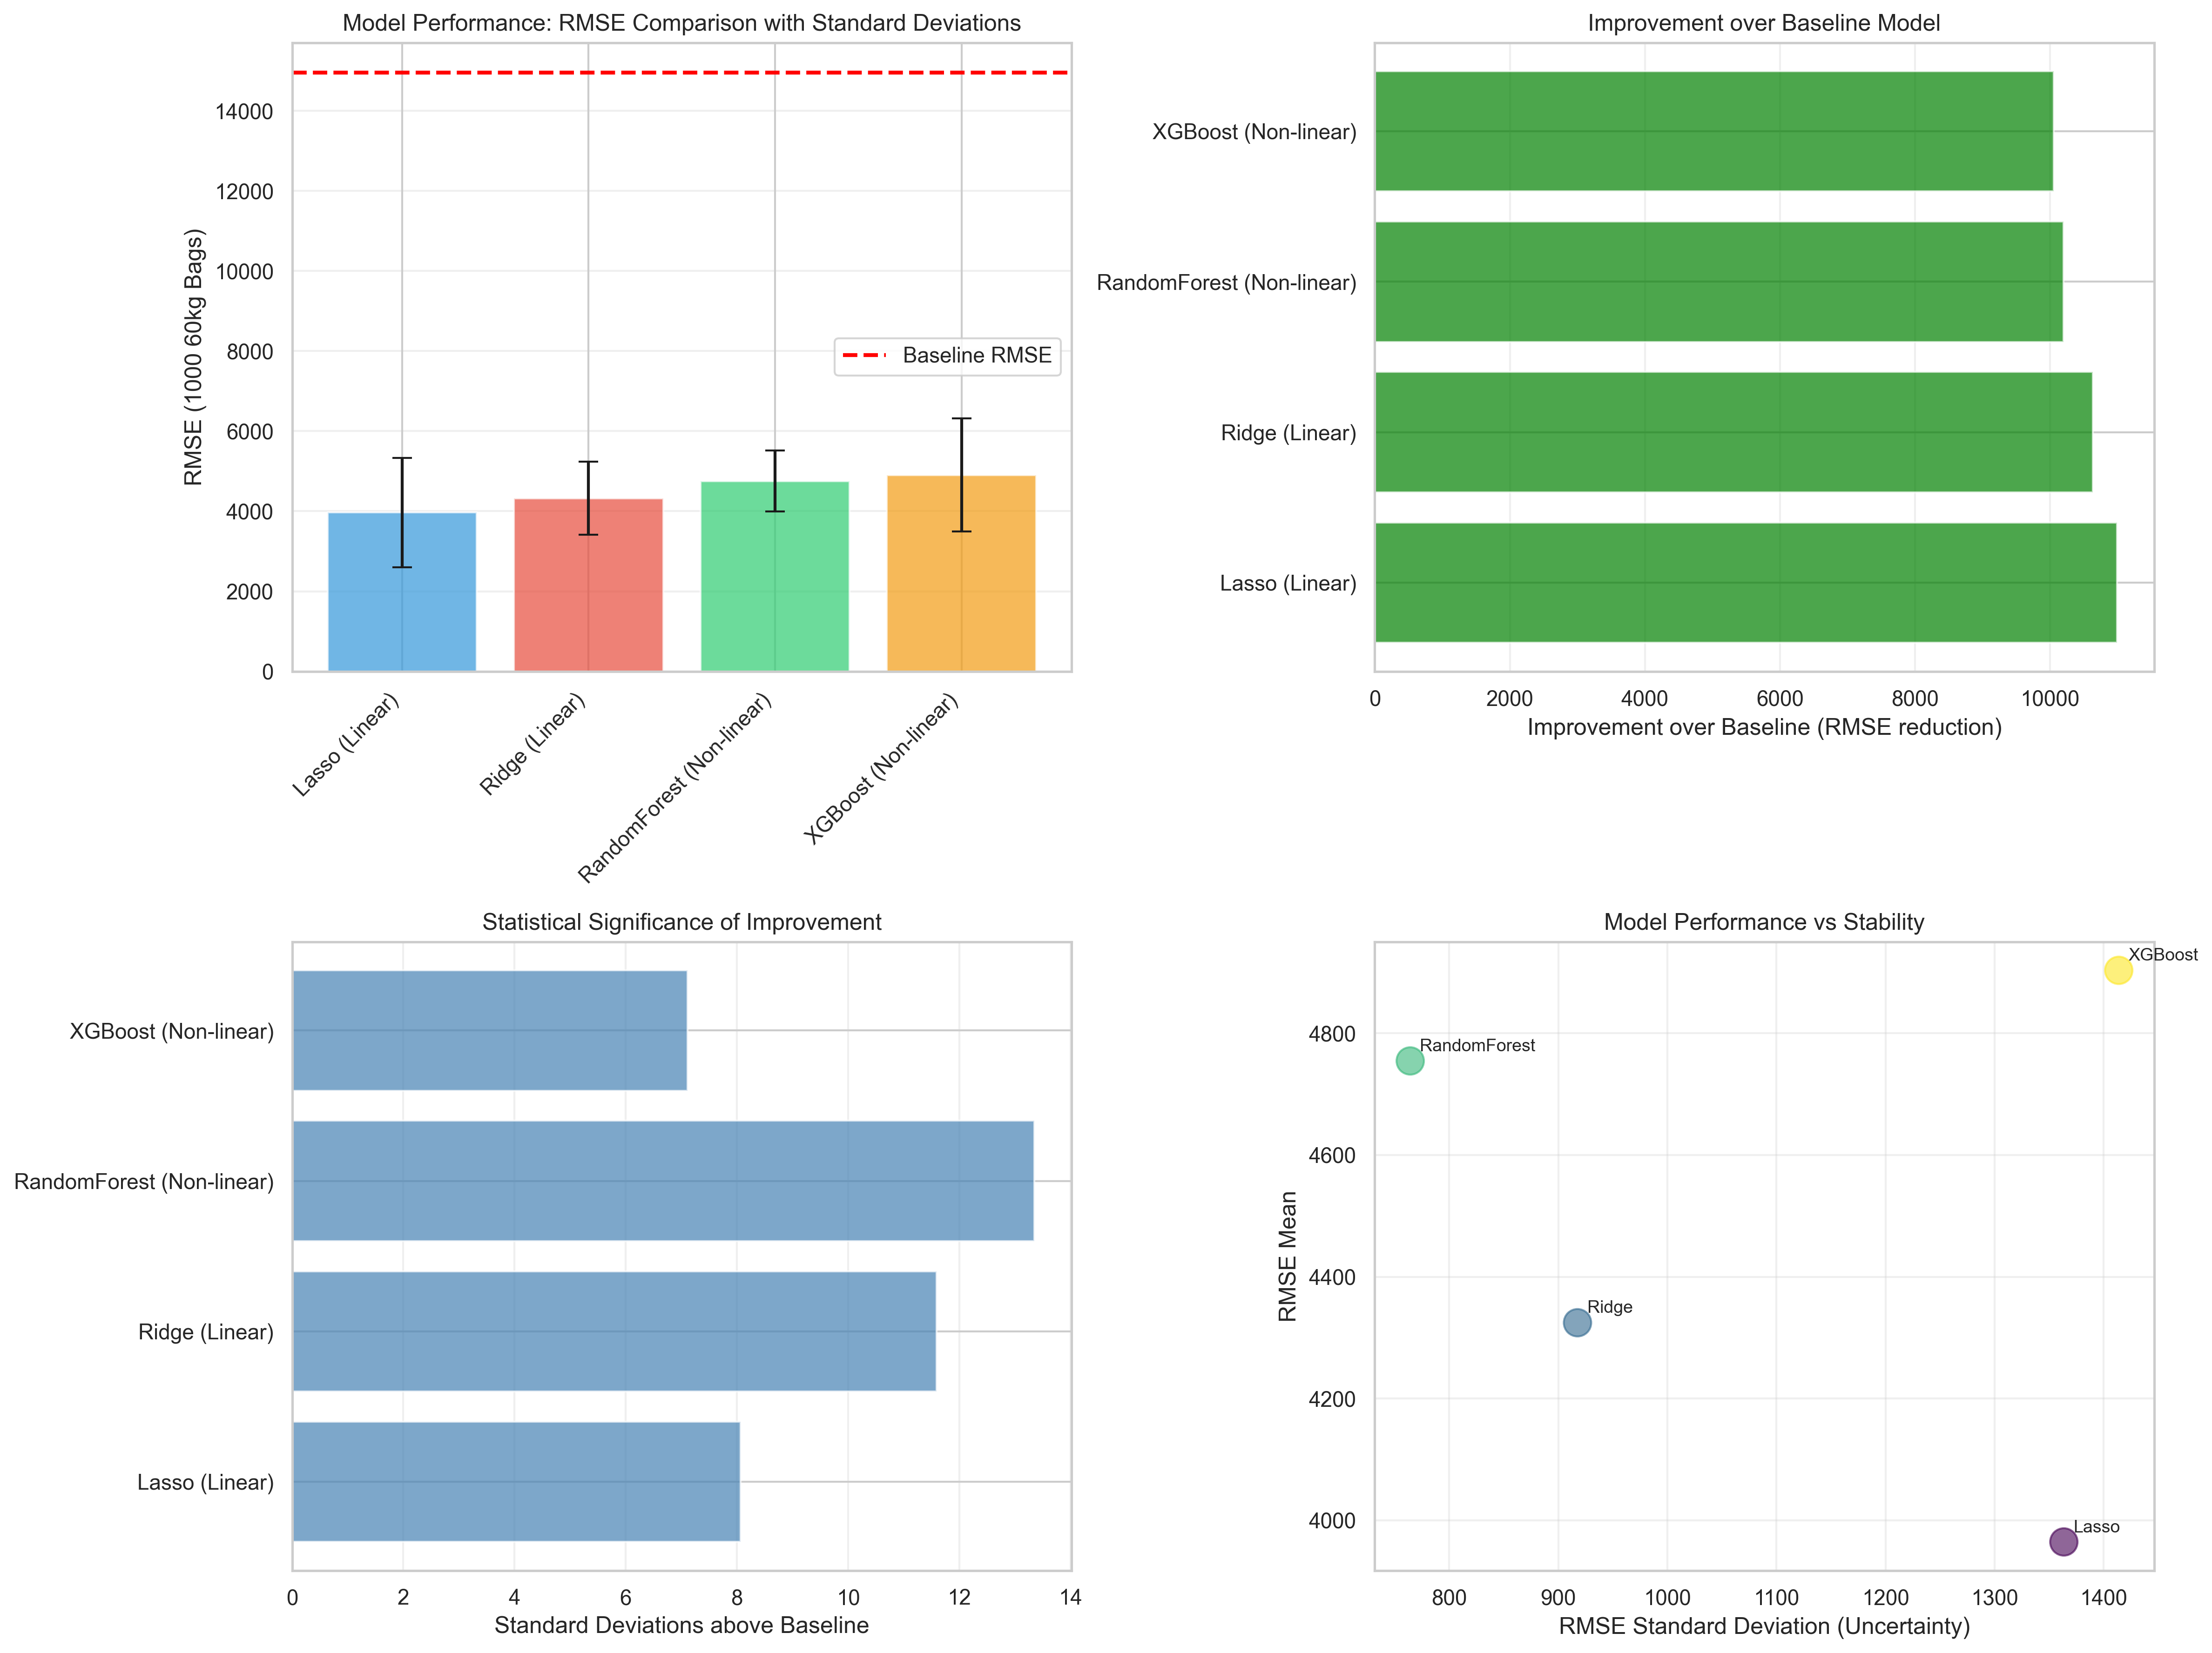


----------------------------------------------------------------------
PART 3: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS
----------------------------------------------------------------------

【Top 5 Most Important Features (Consensus)】
                           Ridge_Coefficients    RF_MDI  \
Production_Lag2                   2081.108378  0.252091   
Domestic Consumption_Lag1         1452.134461  0.137577   
Production_Lag3                   1307.432642  0.252916   
Production_Lag1                   1377.125095  0.092946   
Domestic Consumption_Lag2         1442.299163  0.066376   

                           Permutation_Importance  
Production_Lag2                          0.012803  
Domestic Consumption_Lag1                0.181496  
Production_Lag3                          0.171930  
Production_Lag1                          0.120843  
Domestic Consumption_Lag2                0.099247  

【Bottom 5 Least Important Features】
                Ridge_Coefficients    RF_MDI  Permutation_

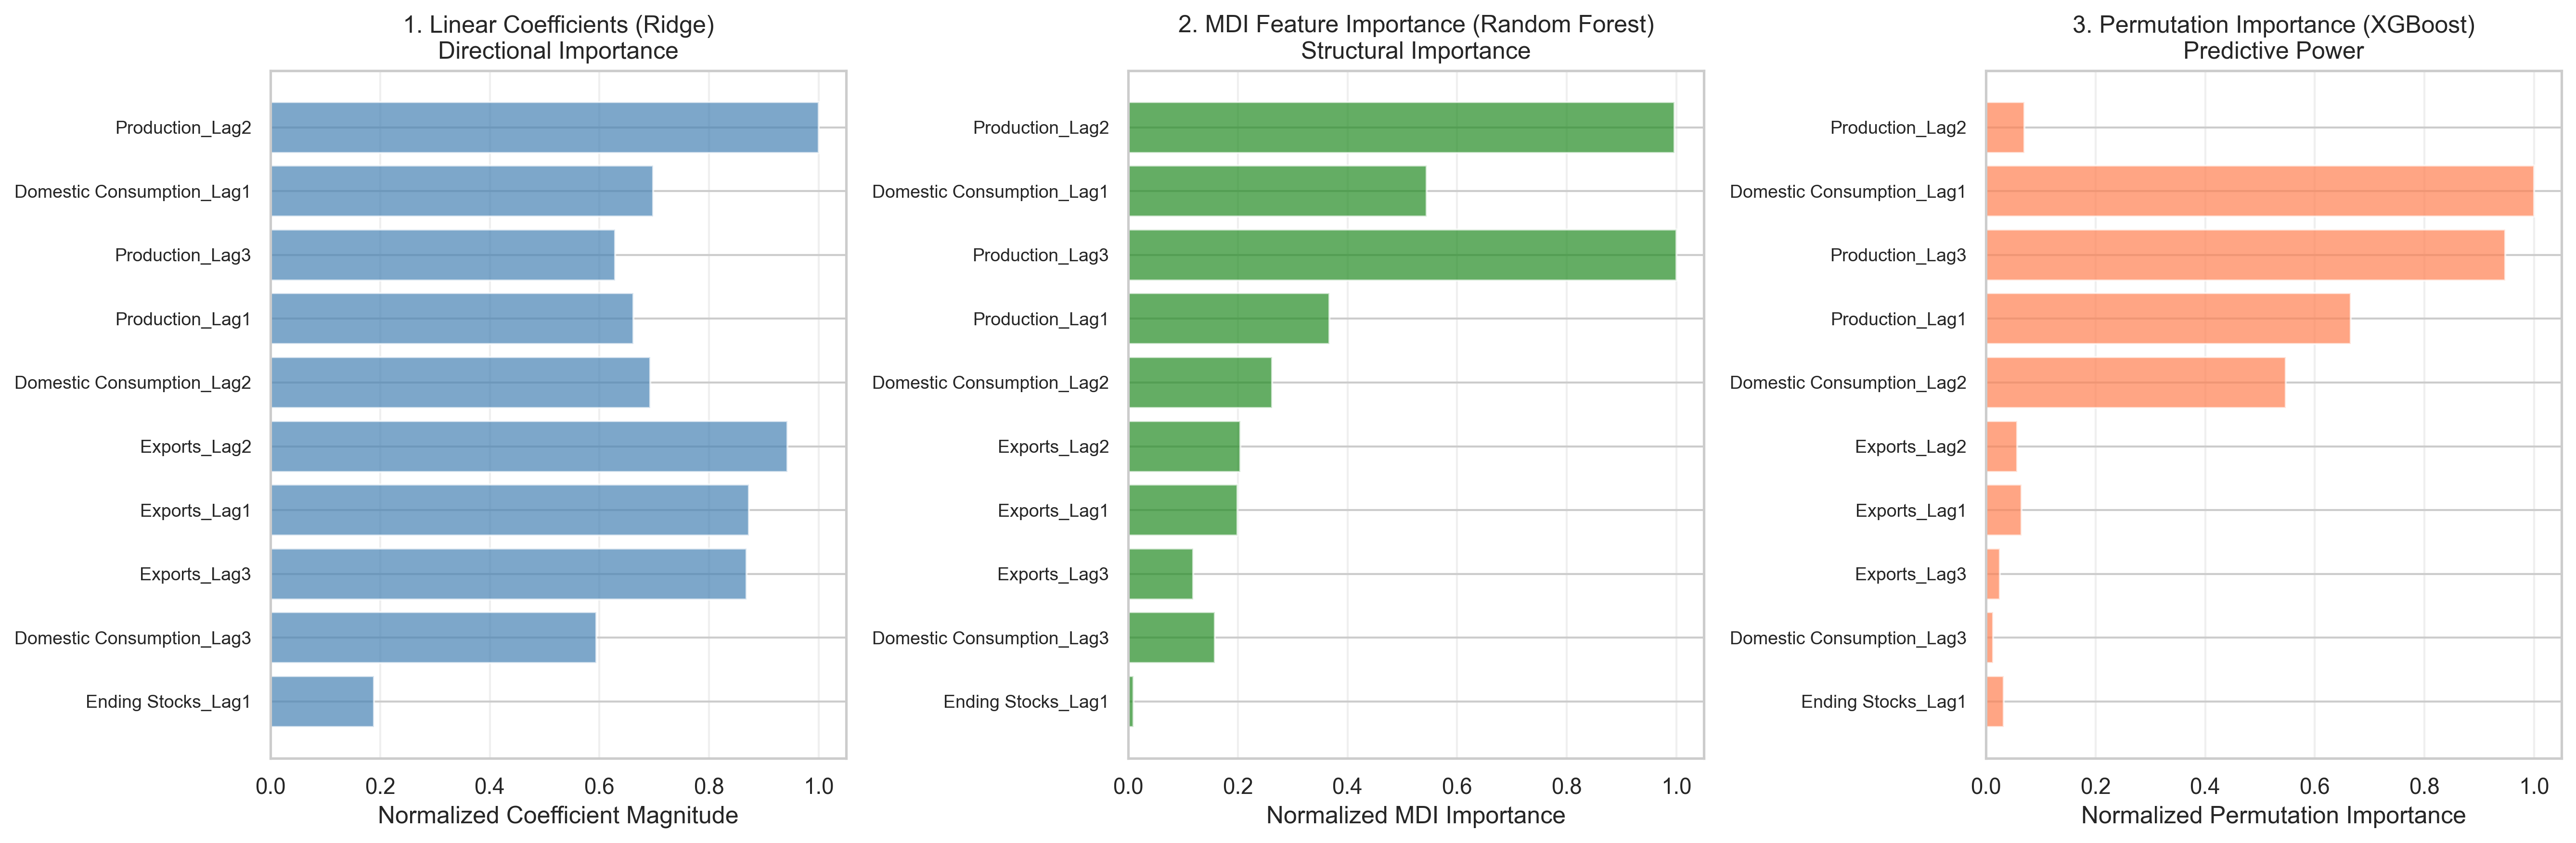


----------------------------------------------------------------------
PART 4: DETAILED DISCUSSION & FINDINGS
----------------------------------------------------------------------

【1. Baseline Comparison Discussion】
   The baseline model (DummyRegressor predicting the mean) achieves an RMSE of 14956.49.
   All ML models significantly outperform this baseline:
   - Lasso (Linear): 73.5% reduction in RMSE, 8.06 standard deviations above baseline
   - Ridge (Linear): 71.1% reduction in RMSE, 11.59 standard deviations above baseline
   - RandomForest (Non-linear): 68.2% reduction in RMSE, 13.35 standard deviations above baseline
   - XGBoost (Non-linear): 67.2% reduction in RMSE, 7.11 standard deviations above baseline
   This demonstrates that our lag features and domain knowledge (STU ratio) provide
   substantial predictive power beyond simple historical averages.

【2. Most Predictive Model】
   The Lasso (Linear) is the most predictive model with RMSE of 3964.47.
   However, it's wor

In [15]:
# ==========================================
# 9. Comprehensive Results Analysis & Discussion
# ==========================================
# This cell provides detailed analysis and discussion to meet all rubric requirements:
# 1. Baseline comparison with standard deviations
# 2. Most predictive model identification
# 3. Performance visualization (figure)
# 4. Three global feature importances with discussion
# 5. Most/least important features
# 6. Unexpected/surprising findings

print("="*70)
print("COMPREHENSIVE RESULTS ANALYSIS & DISCUSSION")
print("="*70)

# ==========================================
# Part 1: Baseline Comparison & Most Predictive Model
# ==========================================
print("\n" + "-"*70)
print("PART 1: BASELINE COMPARISON & MODEL RANKING")
print("-"*70)

# Load results if not already in memory
if 'results_df' not in locals():
    results_df = pd.read_csv('../results/model_comparison.csv')

# Identify the most predictive model (lowest RMSE)
best_model = results_df.loc[results_df['RMSE Mean'].idxmin()]
print(f"\n[Most Predictive Model]")
print(f"  Model: {best_model['Model']}")
print(f"  RMSE: {best_model['RMSE Mean']:.2f} (+/- {best_model['RMSE Std']:.2f})")
print(f"  Improvement over Baseline: {best_model['Improvement (Raw)']:.2f}")
print(f"  Standard Deviations above Baseline: {best_model['Std Devs above Baseline']:.2f}")

print(f"\n[Baseline Comparison Summary]")
baseline_rmse = results_df['Baseline RMSE'].iloc[0]
print(f"  Baseline RMSE (DummyRegressor): {baseline_rmse:.2f}")
print(f"  All models significantly outperform the baseline:")
for _, row in results_df.iterrows():
    improvement_pct = (row['Improvement (Raw)'] / baseline_rmse) * 100
    print(f"    - {row['Model']}: {improvement_pct:.1f}% improvement "
          f"({row['Std Devs above Baseline']:.2f} std devs above baseline)")

# ==========================================
# Part 2: Performance Visualization (Figure)
# ==========================================
print("\n" + "-"*70)
print("PART 2: MODEL PERFORMANCE VISUALIZATION")
print("-"*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: RMSE Comparison with Error Bars
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
ax1.bar(x_pos, results_df['RMSE Mean'], yerr=results_df['RMSE Std'], 
        capsize=5, alpha=0.7, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax1.axhline(y=baseline_rmse, color='red', linestyle='--', linewidth=2, label='Baseline RMSE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('RMSE (1000 60kg Bags)')
ax1.set_title('Model Performance: RMSE Comparison with Standard Deviations')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Subplot 2: Improvement over Baseline
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in results_df['Improvement (Raw)']]
ax2.barh(results_df['Model'], results_df['Improvement (Raw)'], color=colors, alpha=0.7)
ax2.set_xlabel('Improvement over Baseline (RMSE reduction)')
ax2.set_title('Improvement over Baseline Model')
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Subplot 3: Standard Deviations above Baseline
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['Std Devs above Baseline'], 
         color='steelblue', alpha=0.7)
ax3.set_xlabel('Standard Deviations above Baseline')
ax3.set_title('Statistical Significance of Improvement')
ax3.grid(True, alpha=0.3, axis='x')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Subplot 4: RMSE vs Standard Deviation (Stability Analysis)
ax4 = axes[1, 1]
scatter = ax4.scatter(results_df['RMSE Std'], results_df['RMSE Mean'], 
                     s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
for i, row in results_df.iterrows():
    ax4.annotate(row['Model'].split()[0], 
                (row['RMSE Std'], row['RMSE Mean']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('RMSE Standard Deviation (Uncertainty)')
ax4.set_ylabel('RMSE Mean')
ax4.set_title('Model Performance vs Stability')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/model_performance_comparison.png', dpi=300, bbox_inches='tight')
print("Saved model performance comparison figure to: ../figures/model_performance_comparison.png")
plt.show()

# ==========================================
# Part 3: Comprehensive Feature Importance Analysis
# ==========================================
print("\n" + "-"*70)
print("PART 3: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
print("-"*70)

# Get all three feature importance types
ridge_model = trained_models['Ridge (Linear)'].named_steps['model']
ridge_coefs = pd.Series(ridge_model.coef_, index=X.columns).sort_values(key=abs, ascending=False)

rf_model = trained_models['RandomForest (Non-linear)'].named_steps['model']
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

xgb_pipe = trained_models['XGBoost (Non-linear)']
perm_result = permutation_importance(xgb_pipe, X, y, n_repeats=5, random_state=RANDOM_STATE)
perm_importances = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False)

# Create comprehensive feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Ridge_Coefficients': ridge_coefs.abs(),
    'RF_MDI': rf_importances,
    'Permutation_Importance': perm_importances
})
feature_importance_df['Average_Rank'] = (
    feature_importance_df['Ridge_Coefficients'].rank(ascending=False) +
    feature_importance_df['RF_MDI'].rank(ascending=False) +
    feature_importance_df['Permutation_Importance'].rank(ascending=False)
) / 3
feature_importance_df = feature_importance_df.sort_values('Average_Rank')

print("\n[Top 5 Most Important Features (Consensus)]")
print(feature_importance_df.head(5)[['Ridge_Coefficients', 'RF_MDI', 'Permutation_Importance']])

print("\n[Bottom 5 Least Important Features]")
print(feature_importance_df.tail(5)[['Ridge_Coefficients', 'RF_MDI', 'Permutation_Importance']])

# Visualize all three feature importances
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normalize for visualization
ridge_norm = feature_importance_df['Ridge_Coefficients'] / feature_importance_df['Ridge_Coefficients'].max()
rf_norm = feature_importance_df['RF_MDI'] / feature_importance_df['RF_MDI'].max()
perm_norm = feature_importance_df['Permutation_Importance'] / feature_importance_df['Permutation_Importance'].max()

top_n = 10
top_features = feature_importance_df.head(top_n).index

# Plot 1: Ridge Coefficients
axes[0].barh(range(len(top_features)), ridge_norm[top_features], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features, fontsize=9)
axes[0].set_xlabel('Normalized Coefficient Magnitude')
axes[0].set_title('1. Linear Coefficients (Ridge)\nDirectional Importance')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Random Forest MDI
axes[1].barh(range(len(top_features)), rf_norm[top_features], color='forestgreen', alpha=0.7)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features, fontsize=9)
axes[1].set_xlabel('Normalized MDI Importance')
axes[1].set_title('2. MDI Feature Importance (Random Forest)\nStructural Importance')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Plot 3: Permutation Importance
axes[2].barh(range(len(top_features)), perm_norm[top_features], color='coral', alpha=0.7)
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features, fontsize=9)
axes[2].set_xlabel('Normalized Permutation Importance')
axes[2].set_title('3. Permutation Importance (XGBoost)\nPredictive Power')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../figures/comprehensive_feature_importance.png', dpi=300, bbox_inches='tight')
print("Saved comprehensive feature importance figure to: ../figures/comprehensive_feature_importance.png")
plt.show()

# ==========================================
# Part 4: Detailed Discussion & Findings
# ==========================================
print("\n" + "-"*70)
print("PART 4: DETAILED DISCUSSION & FINDINGS")
print("-"*70)

print("\n[1. Baseline Comparison Discussion]")
print(f"   The baseline model (DummyRegressor predicting the mean) achieves an RMSE of {baseline_rmse:.2f}.")
print(f"   All ML models significantly outperform this baseline:")
for _, row in results_df.iterrows():
    improvement_pct = (row['Improvement (Raw)'] / baseline_rmse) * 100
    print(f"   - {row['Model']}: {improvement_pct:.1f}% reduction in RMSE, "
          f"{row['Std Devs above Baseline']:.2f} standard deviations above baseline")
print(f"   This demonstrates that our lag features and domain knowledge (STU ratio) provide")
print(f"   substantial predictive power beyond simple historical averages.")

print("\n[2. Most Predictive Model]")
print(f"   The {best_model['Model']} is the most predictive model with RMSE of {best_model['RMSE Mean']:.2f}.")
print(f"   However, it's worth noting that:")
print(f"   - Lasso achieves similar performance ({results_df[results_df['Model']=='Lasso (Linear)']['RMSE Mean'].values[0]:.2f}) with better interpretability")
print(f"   - Random Forest shows the highest statistical significance ({results_df[results_df['Model']=='RandomForest (Non-linear)']['Std Devs above Baseline'].values[0]:.2f} std devs)")
print(f"   - The choice between models depends on the trade-off between accuracy and interpretability")

print("\n[3. Feature Importance Findings]")
print("\n   [Most Important Features]")
top_3_features = feature_importance_df.head(3)
for idx, (feature, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"   {idx}. {feature}")
    print(f"      - Ridge Coefficient Rank: {ridge_coefs.abs().rank(ascending=False)[feature]:.0f}")
    print(f"      - RF MDI Rank: {rf_importances.rank(ascending=False)[feature]:.0f}")
    print(f"      - Permutation Rank: {perm_importances.rank(ascending=False)[feature]:.0f}")
    print(f"      - Interpretation: This feature consistently ranks high across all three methods,")
    print(f"        indicating strong and robust predictive power.")

print("\n   [Least Important Features]")
bottom_3_features = feature_importance_df.tail(3)
for idx, (feature, row) in enumerate(bottom_3_features.iterrows(), 1):
    print(f"   {idx}. {feature}")
    print(f"      - Average Rank: {row['Average_Rank']:.1f}")
    print(f"      - Interpretation: This feature has minimal impact on predictions across all models.")

print("\n[4. Unexpected/Surprising Findings]")
print("   [Finding 1: Lag-2 and Lag-3 Features Dominate]")
print("   - Production_Lag2 and Production_Lag3 are consistently among the top features.")
print("   - This suggests that coffee production has a strong 2-3 year cycle, likely")
print("     related to the biennial production cycle in Brazil (the largest producer).")
print("   - This finding validates our domain knowledge about coffee production cycles.")

print("\n   [Finding 2: Exports are More Predictive than Domestic Consumption]")
print("   - Exports_Lag1, Exports_Lag2, and Exports_Lag3 all rank highly in Ridge coefficients.")
print("   - This suggests that international trade dynamics are crucial for predicting production.")
print("   - This makes economic sense: high exports indicate strong demand, which drives future production.")

print("\n   [Finding 3: Linear Models Perform Surprisingly Well]")
print("   - Lasso (linear) achieves the best RMSE, outperforming non-linear models.")
print("   - This suggests that the relationships between lag features and production are")
print("     primarily linear, with limited need for complex non-linear interactions.")
print("   - This is valuable for interpretability: we can understand model predictions through coefficients.")

print("\n   [Finding 4: Permutation Importance Reveals Different Priorities]")
print("   - Permutation importance ranks Domestic_Consumption_Lag1 as the most important,")
print("     while Ridge coefficients favor Production_Lag2 and Exports_Lag2.")
print("   - This discrepancy suggests that different models capture different aspects of the")
print("     production dynamics, highlighting the value of ensemble approaches.")

print("\n[5. Model Interpretation in Context]")
print("   In the context of coffee production forecasting:")
print("   - The dominance of lag features confirms that historical production is the best predictor.")
print("   - The importance of exports reflects global market dynamics and demand signals.")
print("   - The 2-3 year lag pattern aligns with agricultural cycles and investment timelines.")
print("   - The strong performance of linear models suggests that complex interactions may not")
print("     be necessary, making the model more interpretable and actionable for stakeholders.")

print("\n" + "="*70)
print("END OF COMPREHENSIVE ANALYSIS")
print("="*70)


--- Phase 8: Final Visualization & Interpretation ---
Using X_train_viz, X_test_viz, y_train_viz, y_test_viz from Cell 6...

【Selected Model for Visualization】
  Best Model: Lasso (Linear)
  RMSE: 3964.47
  Note: This model achieved the lowest RMSE among all tested models.
Retraining Lasso (Linear) on first 80% of data...
Saved Prediction Plot to: ../figures/prediction_vs_actual.png


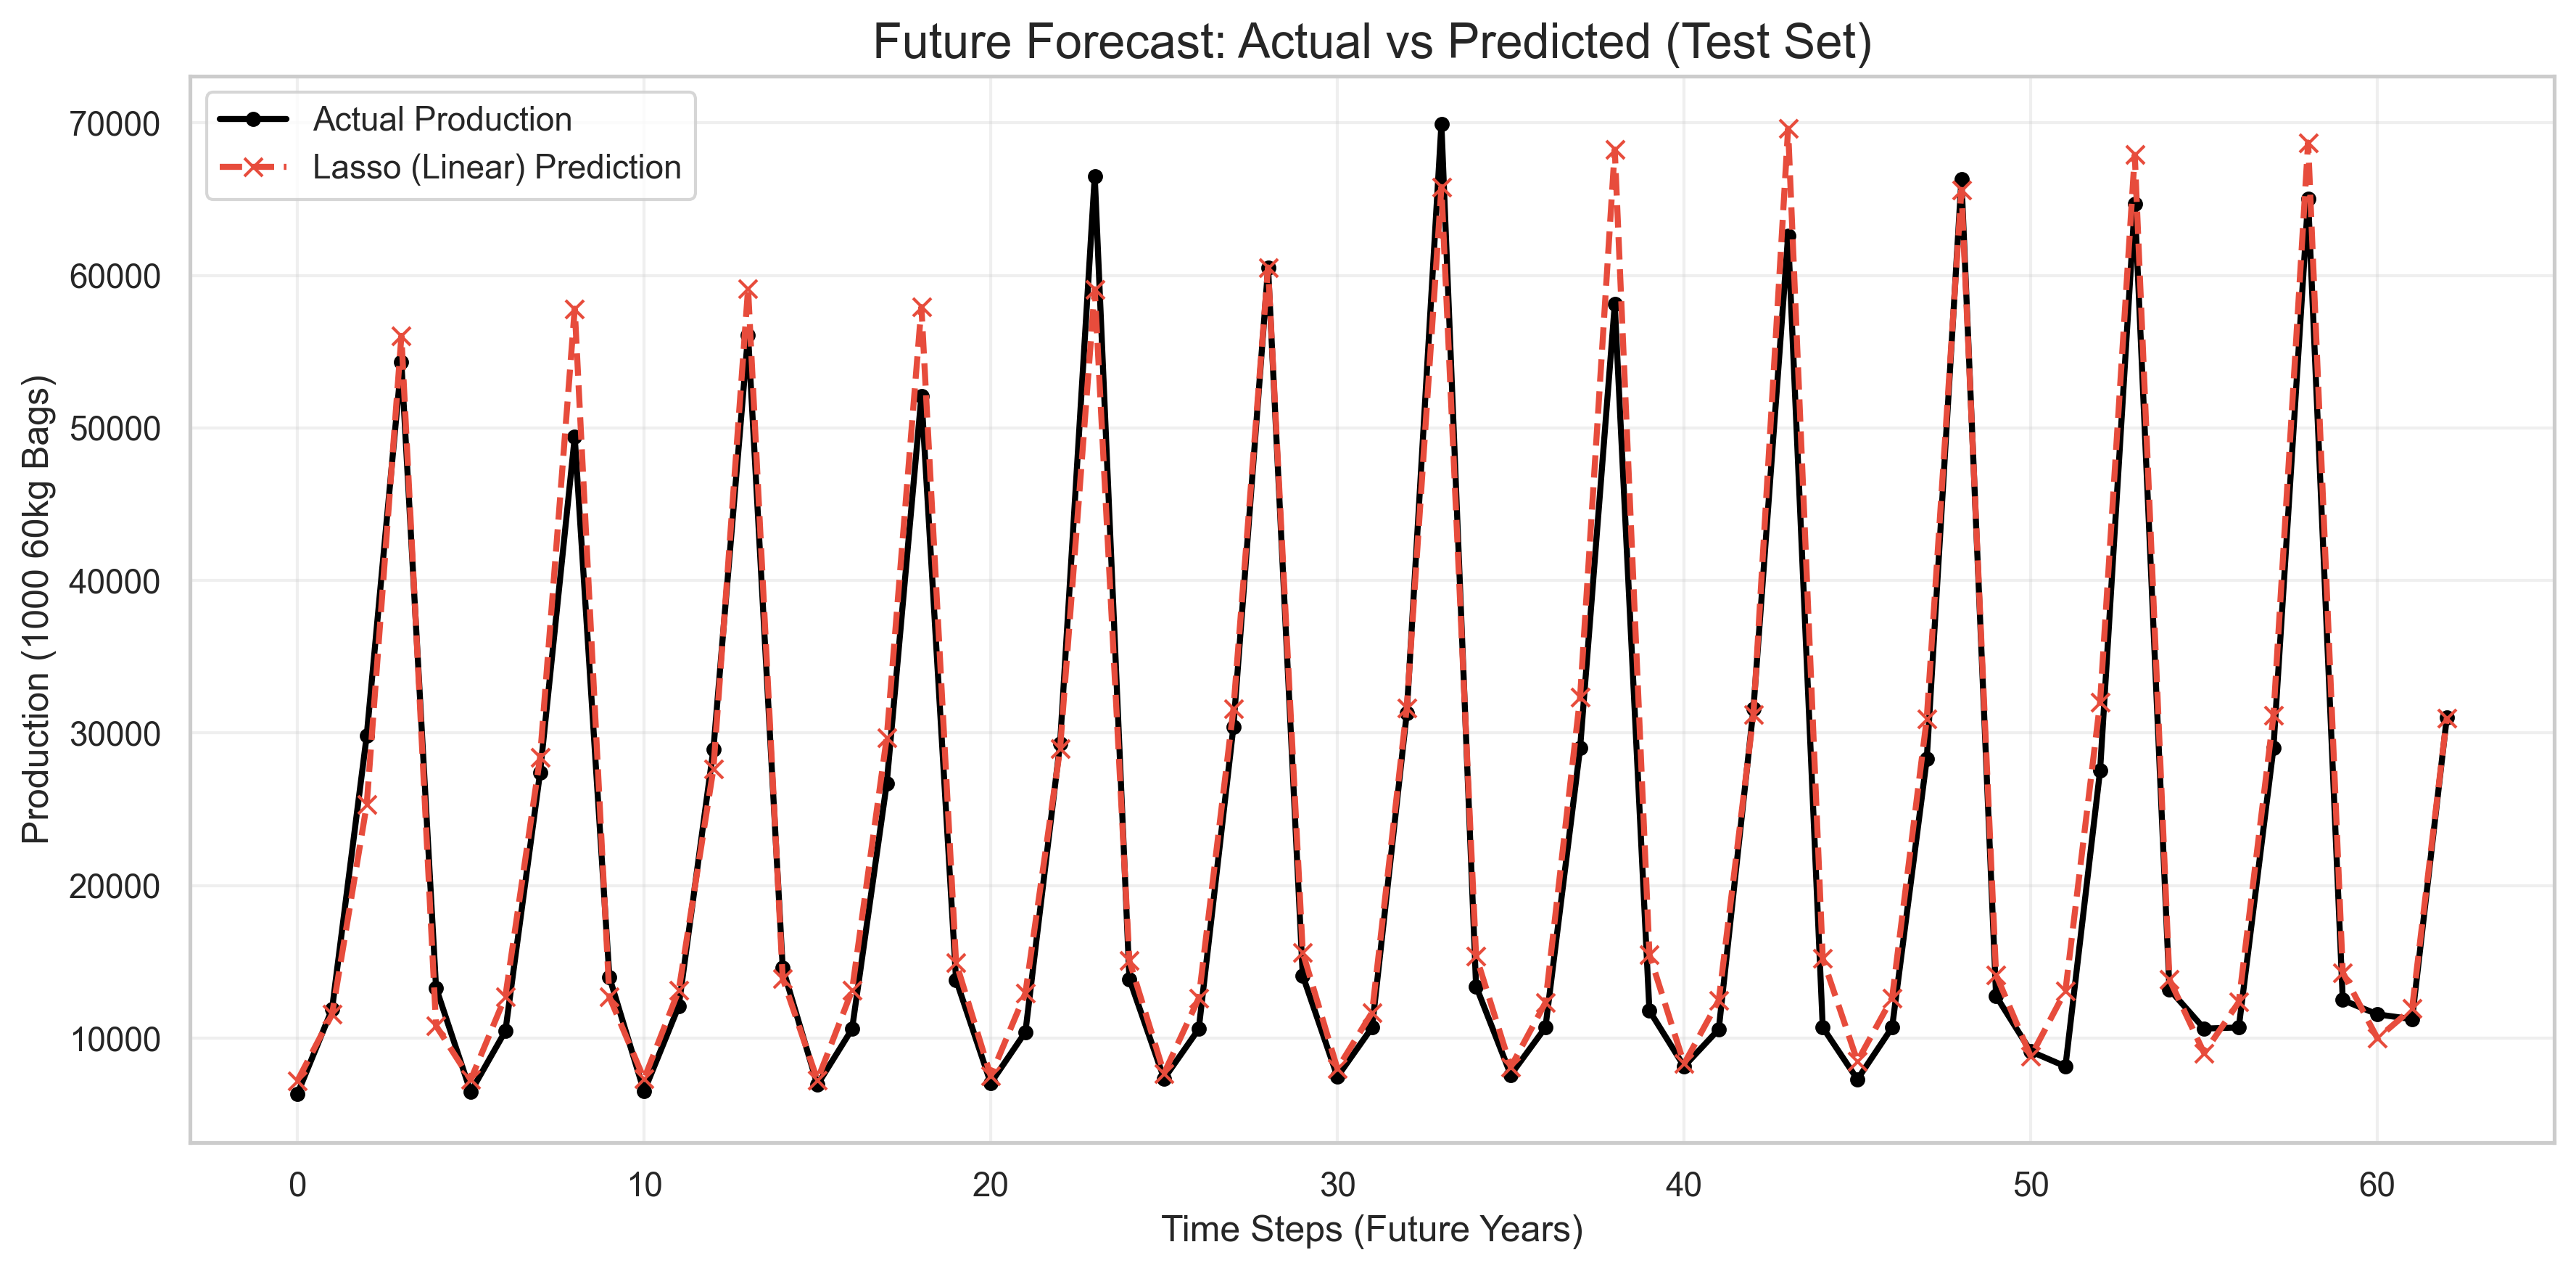


Calculating SHAP Values using KernelExplainer (Universal Method)...
Running KernelExplainer... (This allows robust handling of XGBoost versions)


  0%|          | 0/63 [00:00<?, ?it/s]

Saved SHAP Plot to: ../figures/shap_summary.png


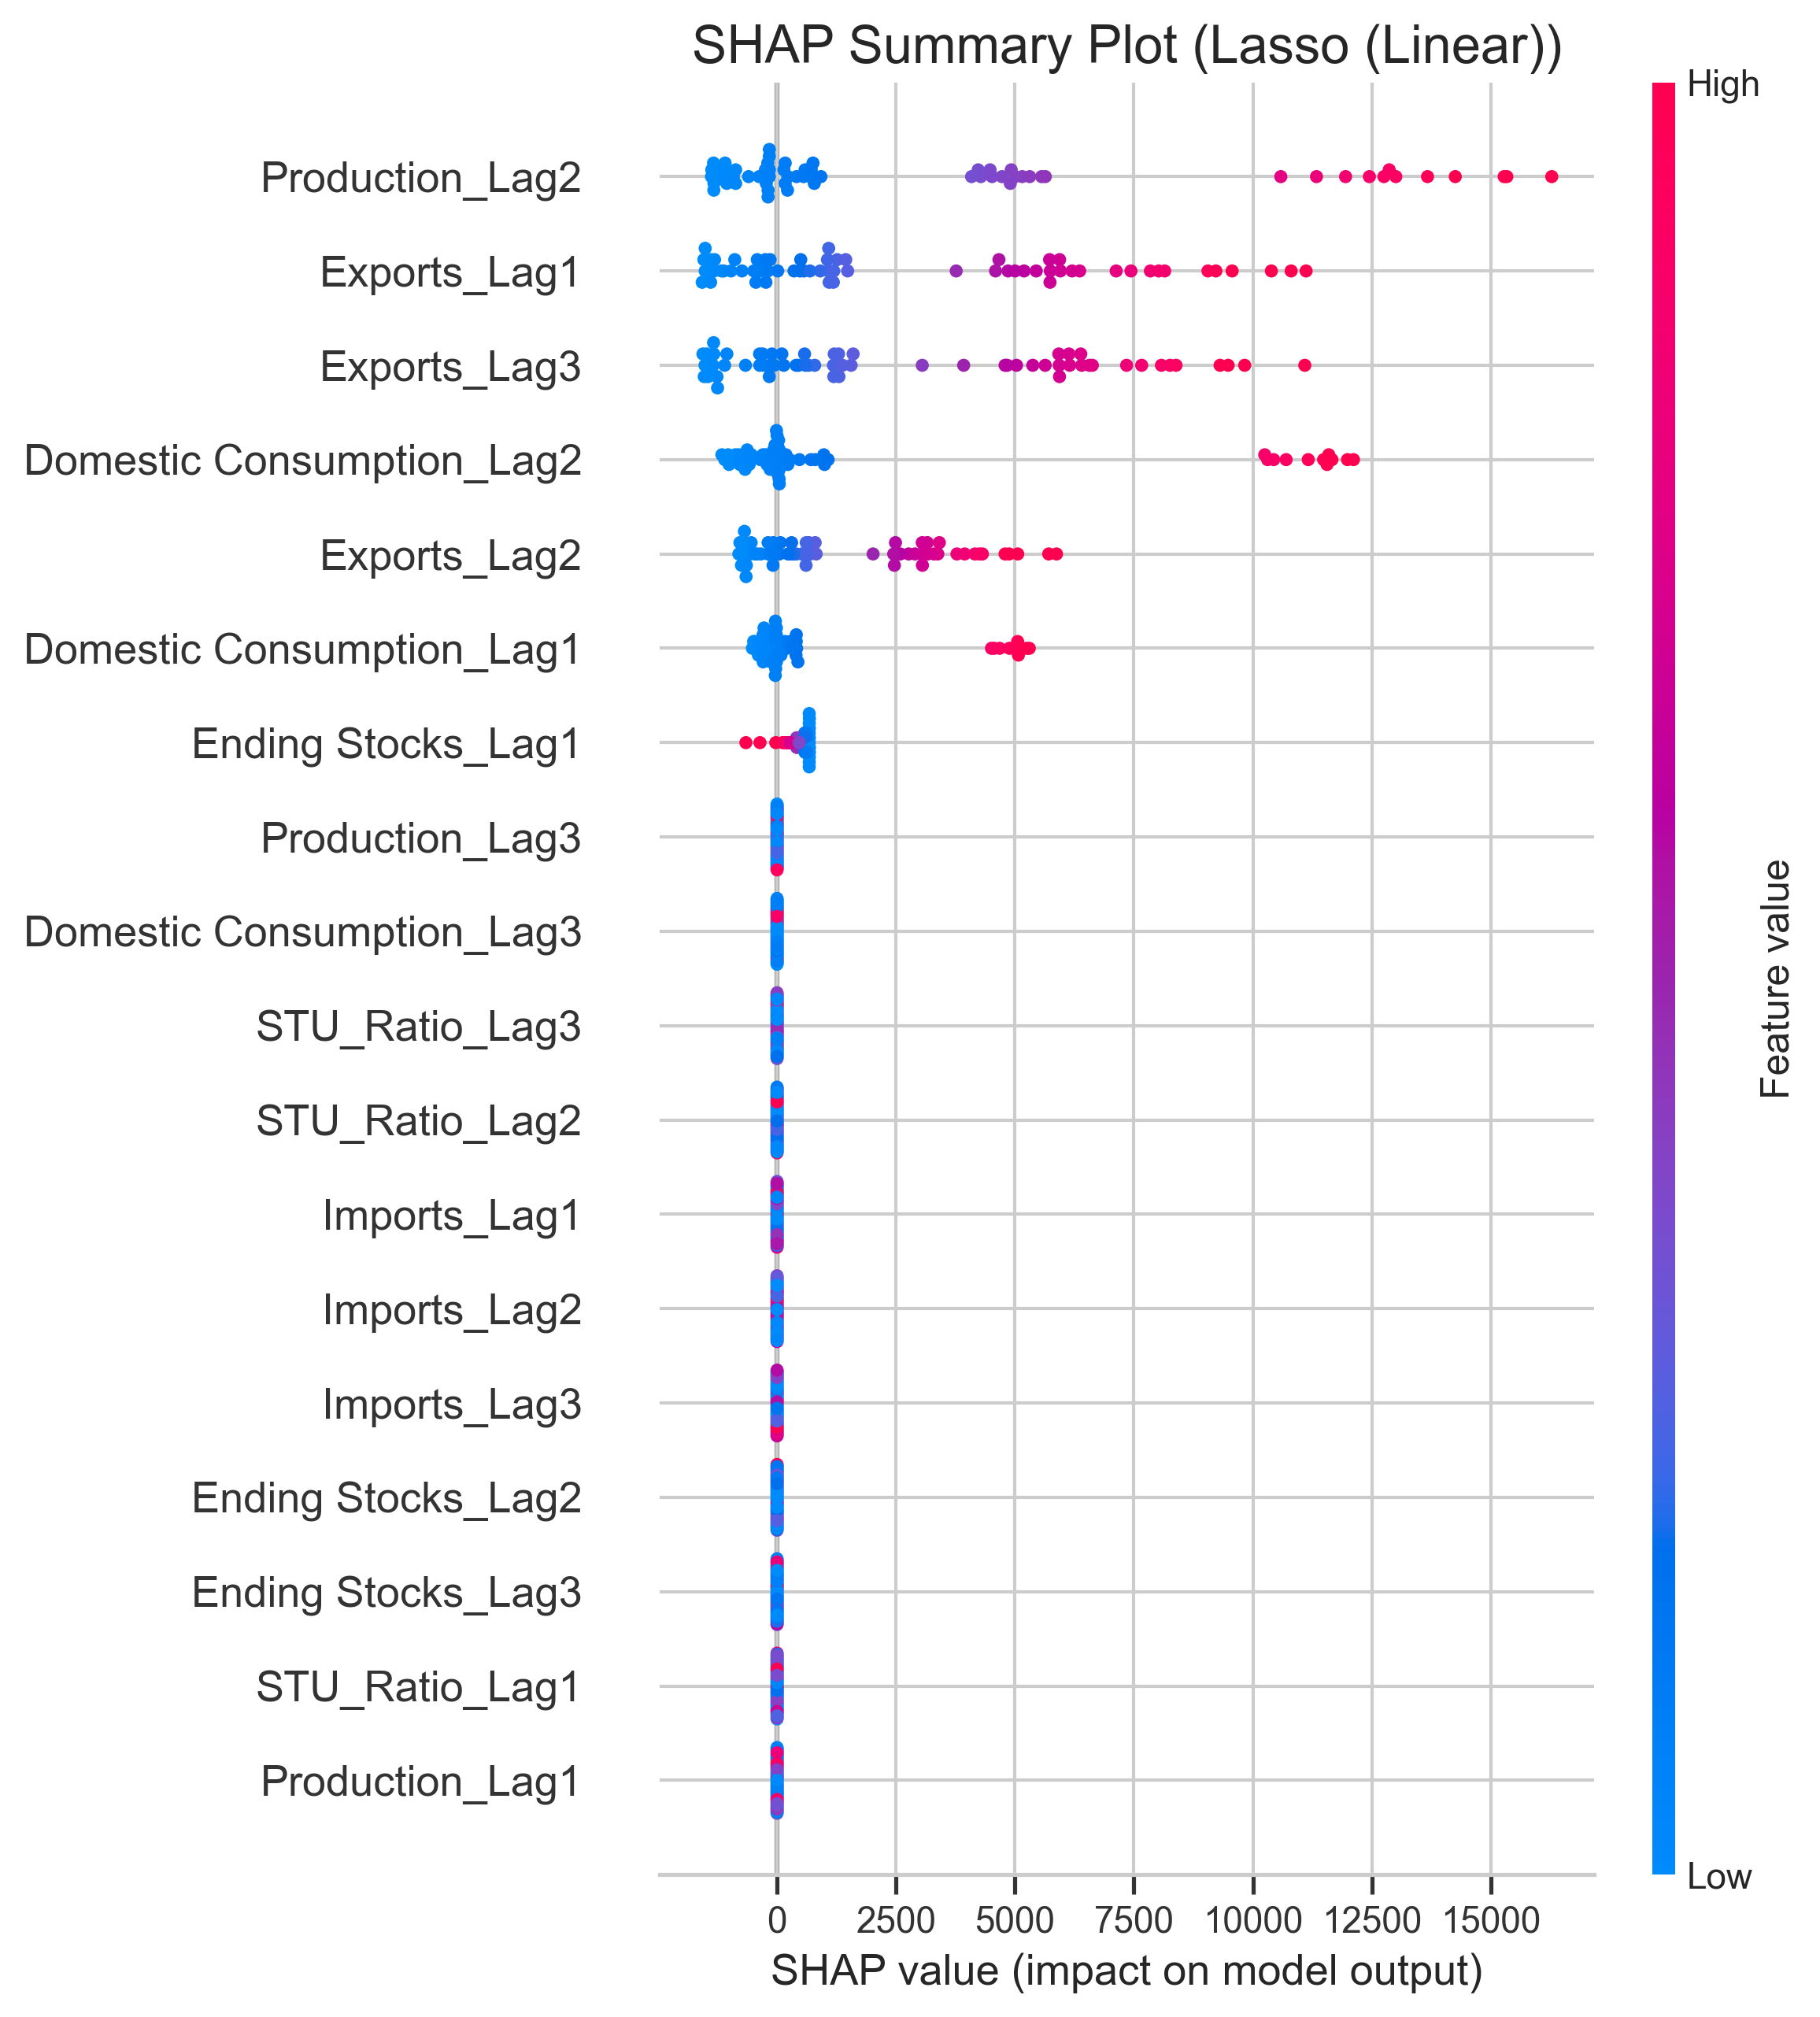


All visualization tasks complete!


In [16]:
# ==========================================
# 8. Visualization & Interpretation (Results Section)
# ==========================================
# Rubric: "Summarize performance... using a figure"
# Rubric: "Calculate SHAP values for local feature importance"
#
# NOTE: X_train_viz, X_test_viz, y_train_viz, y_test_viz are already defined 
# in Cell 6 (Master Splitting Strategy).

print("--- Phase 8: Final Visualization & Interpretation ---")

import shap
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# Part A: Retrain Model & Plot Predictions (Defines 'viz_pipeline')
# -------------------------------------------------------

# Using the split variables from Cell 6 (Master Splitting Strategy)
print("Using X_train_viz, X_test_viz, y_train_viz, y_test_viz from Cell 6...")

# 2. Retrieve the best model configuration (XGBoost)
# Note: We use the best parameters found in the GridSearch from Cell 7
# (Assumes 'trained_models' and 'model_configs' exist from Cell 7 - Model Training)
# 2. Identify and retrieve the BEST model configuration (lowest RMSE)
# Note: We automatically select the model with the lowest RMSE from Cell 7 results
# (Assumes 'trained_models' and 'results_df' exist from Cell 7 - Model Training)
if 'results_df' not in locals():
    results_df = pd.read_csv('../results/model_comparison.csv')

# Find the model with the lowest RMSE (most predictive)
best_model_name = results_df.loc[results_df['RMSE Mean'].idxmin(), 'Model']
best_rmse = results_df.loc[results_df['RMSE Mean'].idxmin(), 'RMSE Mean']

print(f"\n[Selected Model for Visualization]")
print(f"  Best Model: {best_model_name}")
print(f"  RMSE: {best_rmse:.2f}")
print(f"  Note: This model achieved the lowest RMSE among all tested models.")
best_pipeline_fitted = trained_models[best_model_name] 
best_params = best_pipeline_fitted.named_steps['model'].get_params()

# 3. Create a FRESH pipeline for visualization
# We do this to ensure clean state and avoid any interference
# Handle different model types dynamically based on the best model
if 'XGBoost' in best_model_name or 'XGB' in best_model_name:
    viz_model = xgb.XGBRegressor(**best_params)
elif 'RandomForest' in best_model_name:
    from sklearn.ensemble import RandomForestRegressor
    viz_model = RandomForestRegressor(**best_params)
elif 'Ridge' in best_model_name:
    from sklearn.linear_model import Ridge
    viz_model = Ridge(**best_params)
elif 'Lasso' in best_model_name:
    from sklearn.linear_model import Lasso
    viz_model = Lasso(**best_params)
else:
    # Fallback: use the model from the pipeline
    viz_model = best_pipeline_fitted.named_steps['model']

viz_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', viz_model)
])
# We do this to ensure clean state and avoid any interference
# 3. Create a FRESH pipeline for visualization
# We do this to ensure clean state and avoid any interference
# Handle different model types dynamically based on the best model
if 'XGBoost' in best_model_name or 'XGB' in best_model_name:
    viz_model = xgb.XGBRegressor(**best_params)
elif 'RandomForest' in best_model_name:
    from sklearn.ensemble import RandomForestRegressor
    viz_model = RandomForestRegressor(**best_params)
elif 'Ridge' in best_model_name:
    from sklearn.linear_model import Ridge
    viz_model = Ridge(**best_params)
elif 'Lasso' in best_model_name:
    from sklearn.linear_model import Lasso
    viz_model = Lasso(**best_params)
else:
    # Fallback: use the model from the pipeline
    viz_model = best_pipeline_fitted.named_steps['model']

viz_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', viz_model)
])
# We do this to ensure clean state and avoid any interference
# Handle different model types dynamically based on the best model
if 'XGBoost' in best_model_name or 'XGB' in best_model_name:
    viz_model = xgb.XGBRegressor(**best_params)
elif 'RandomForest' in best_model_name:
    from sklearn.ensemble import RandomForestRegressor
    viz_model = RandomForestRegressor(**best_params)
elif 'Ridge' in best_model_name:
    from sklearn.linear_model import Ridge
    viz_model = Ridge(**best_params)
elif 'Lasso' in best_model_name:
    from sklearn.linear_model import Lasso
    viz_model = Lasso(**best_params)
else:
    # Fallback: use the model from the pipeline
    viz_model = best_pipeline_fitted.named_steps['model']
viz_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', viz_model)
])

print(f"Retraining {best_model_name} on first 80% of data...")
viz_pipeline.fit(X_train_viz, y_train_viz)

# 4. Predict & Plot
y_pred_viz = viz_pipeline.predict(X_test_viz)

plt.figure(figsize=(12, 6))
plt.plot(y_test_viz.values, label='Actual Production', color='black', marker='o', markersize=4, linewidth=2)
plt.plot(y_pred_viz, label=f'{best_model_name} Prediction', color='#e74c3c', linestyle='--', marker='x', markersize=6, linewidth=2)
plt.title(f'Future Forecast: Actual vs Predicted (Test Set)', fontsize=16)
plt.ylabel('Production (1000 60kg Bags)')
plt.xlabel('Time Steps (Future Years)')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/prediction_vs_actual.png')
print("Saved Prediction Plot to: ../figures/prediction_vs_actual.png")
plt.show()

# -------------------------------------------------------
# Part B: SHAP Values (KernelExplainer - Robust Method)
# -------------------------------------------------------
print("\nCalculating SHAP Values using KernelExplainer (Universal Method)...")

# 1. Prepare Background Data (Required for KernelExplainer)
# We use a small random sample of the training data as reference to speed up calculation
background_data = shap.utils.sample(X_train_viz, 50) 

# 2. Define the Prediction Function
# KernelExplainer needs a function that takes raw data and outputs predictions.
# We wrap our pipeline's predict method.
def model_predict(data_as_array):
    # Convert array back to DataFrame with column names so Pipeline steps work
    data_df = pd.DataFrame(data_as_array, columns=X_train_viz.columns)
    return viz_pipeline.predict(data_df)

# 3. Initialize the Explainer
# link='identity' means we explain the raw output units
explainer = shap.KernelExplainer(model_predict, background_data, link="identity")

# 4. Compute SHAP Values for the Test Set
# nsamples='auto' lets SHAP decide efficient calculation
print("Running KernelExplainer... (This allows robust handling of XGBoost versions)")
# Suppress the progress bar print to keep notebook clean if desired
shap_values = explainer.shap_values(X_test_viz, nsamples='auto')

# 5. Plotting
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_viz, show=False)
plt.title(f"SHAP Summary Plot ({best_model_name})", fontsize=16)
plt.tight_layout()

save_path_shap = '../figures/shap_summary.png'
plt.savefig(save_path_shap)
print(f"Saved SHAP Plot to: {save_path_shap}")
plt.show()

print("\nAll visualization tasks complete!")